In [ ]:
"""
https://rieltor.ua/rovno/flats-sale/?sort=-byprice#9.05/50.7127/26.6092
https://dom.ria.com/uk/realty-prodaja-kvartira-rovno-tsentr-mira-prospekt-26769486.html
https://forbes.ua/money/budivnitstva-ne-zapuskayutsya-popitu-nemae-ale-tsini-ne-padayut-doslidzhennya-rinku-nerukhomosti-pid-chas-viyni-vid-ernst-amp-young-13032023-12337
https://ua.m2bomber.com/stat/448930/view/rivne?type=flat-sell

M2Bomber
dom.ria.com
realtor.ua
forbes.ua

Вартість в доларах із-за нестабільності курса валют 

Будівництво скоротилоcя майже всюди, попит обвалився, але ціни не падають. Дослідження ринку нерухомості під час війни від Ernst & Young. 


"""


In [8]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from xgboost import XGBRegressor
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# завантаження файлу щоб код працював на інших платформах і незалежно від шляхів до файлів.
data = "data1.xlsx"
file_path = os.path.join(os.getcwd(), data)

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
else:
    print(f"Файл {data} не знайдений.")

# Тепер мій датасет зберігається в об'єкті DataFrame з Pandas (df)


In [3]:
# Виведення перших 5 рядків датасету
print(df.head())

      Район Тип житла  Загальна площа (м²)  Кількість кімнат  \
0  12-школа   Будинок                   59                 3   
1  12-школа   Будинок                   90                 2   
2  12-школа  Таунхауз                  151                 3   
3  12-школа   Будинок                  240                 4   
4  12-школа   Будинок                   90                 2   

   1 новий / 2 вторични й ринок  к-сть поверхів будинку  Ціна в $/м²  \
0                             2                       1         1644   
1                             2                       1         1500   
2                             2                       2         1656   
3                             2                       2         1417   
4                             2                       1         1500   

   Своя Парковка (1-є 0-не має)  Земельний участок (соток)  Вартість  \
0                             1                          4     96996   
1                             1       

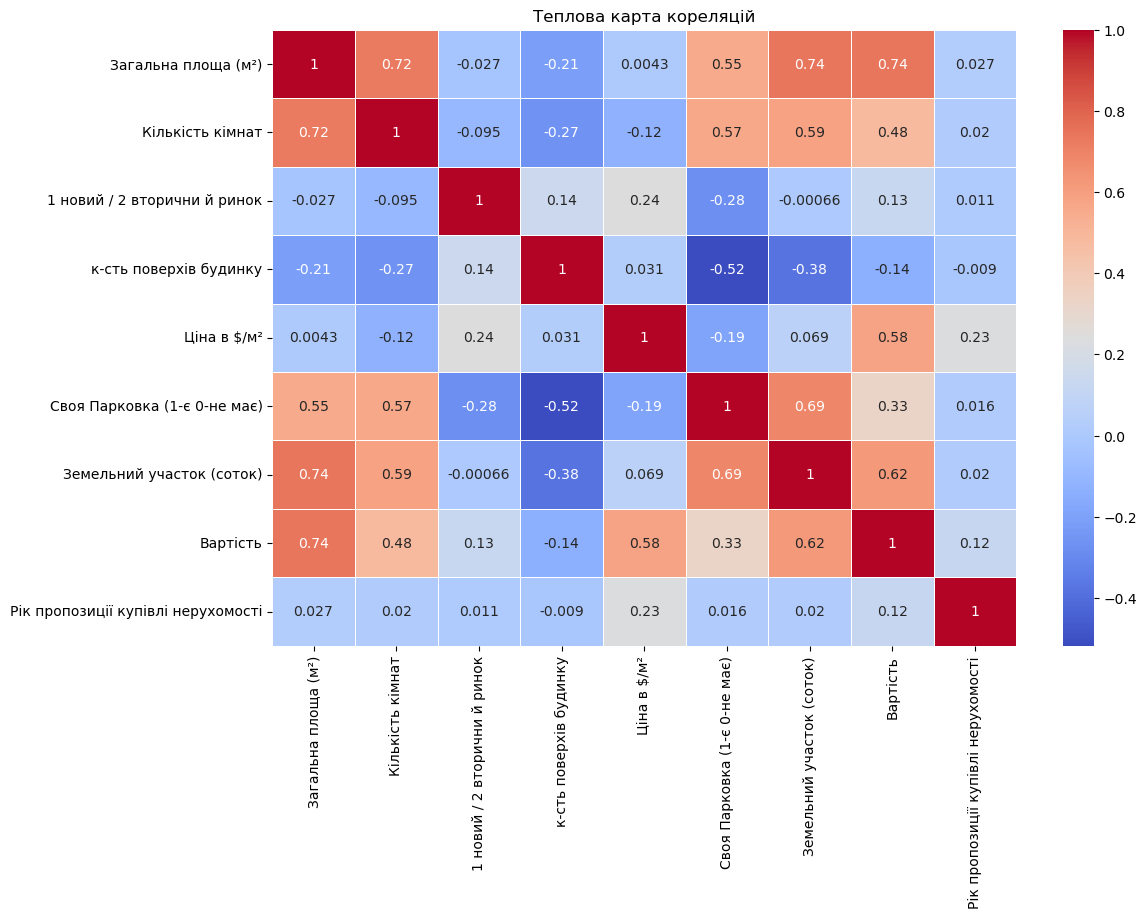

In [10]:
# приховати попередження
warnings.filterwarnings("ignore")

# візуалізація залежностей між даними датасету
"""
Позитивна кореляція (значення більше 0) вказує що, якщо одна змінна зростає, інша також зростає.
Негативна кореляція (значення менше 0) означає, що, якщо одна змінна зростає, інша зменшується. Тобто обидві змінні рухаються в протилежних напрямках.
Відсутність кореляції (значення близьке до 0) означає, що між змінними немає сильного статистичного зв'язку.
"""
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Теплова карта кореляцій')
plt.show()

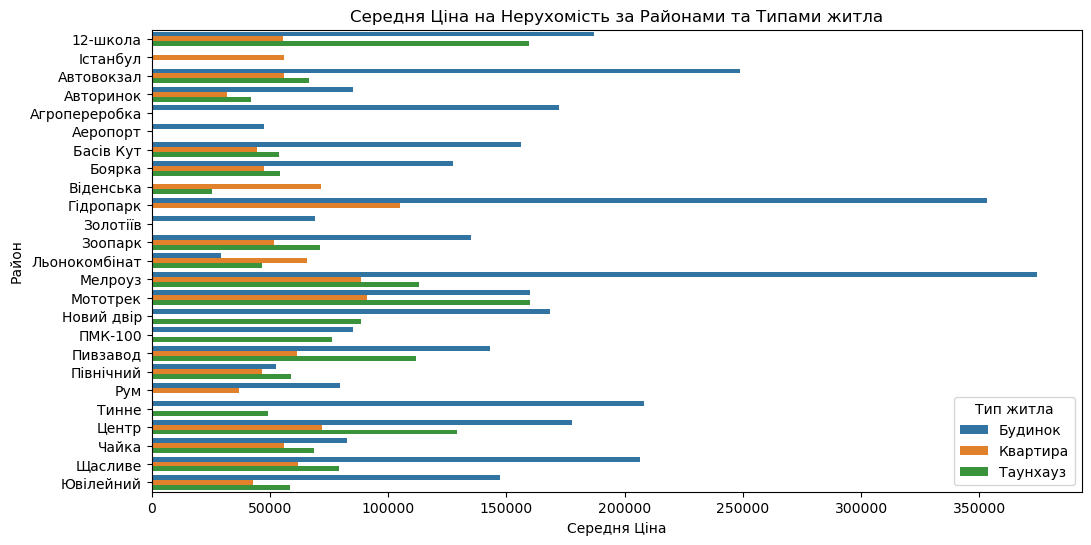

In [5]:
# Групування даних за районом та типом житла та обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка "bar plot" з розділенням за типом житла
plt.figure(figsize=(12, 6))
sns.barplot(x='Вартість', y='Район', hue='Тип житла', data=grouped_data, orient='h')
plt.xlabel('Середня Ціна')
plt.ylabel('Район')
plt.title('Середня Ціна на Нерухомість за Районами та Типами житла')
plt.show()


In [6]:
# Виведення загальної інформації про датасет
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2314 entries, 0 to 2313
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Район                               2314 non-null   object
 1   Тип житла                           2314 non-null   object
 2   Загальна площа (м²)                 2314 non-null   int64 
 3   Кількість кімнат                    2314 non-null   int64 
 4   1 новий / 2 вторични й ринок        2314 non-null   int64 
 5   к-сть поверхів будинку              2314 non-null   int64 
 6   Ціна в $/м²                         2314 non-null   int64 
 7   Своя Парковка (1-є 0-не має)        2314 non-null   int64 
 8   Земельний участок (соток)           2314 non-null   int64 
 9   Вартість                            2314 non-null   int64 
 10  Рік пропозиції купівлі нерухомості  2314 non-null   int64 
dtypes: int64(9), object(2)
memory usage: 199.0+ KB
None


In [7]:
# Групування даних за роками і обчислення середнього значення цін
average_prices_by_year = df.groupby(['Рік пропозиції купівлі нерухомості'])['Вартість'].mean().reset_index()

# Додавання стовпця для відсотку зміни
average_prices_by_year['Відсоток зміни'] = average_prices_by_year['Вартість'].pct_change() * 100

# Вивід результату
print(average_prices_by_year)

   Рік пропозиції купівлі нерухомості      Вартість  Відсоток зміни
0                                2020  66860.872624             NaN
1                                2021  77502.884007       15.916650
2                                2022  89911.518900       16.010546
3                                2023  90434.551020        0.581719


In [11]:
# забираю стовпчики які мають менше залежностей з вартістю нерухомості за даними теплової карти кореляції

columns_to_drop = ['к-сть поверхів будинку', 'Своя Парковка (1-є 0-не має)', '1 новий / 2 вторични й ринок', 'Рік пропозиції купівлі нерухомості']
df = df.drop(columns=columns_to_drop, axis=1)

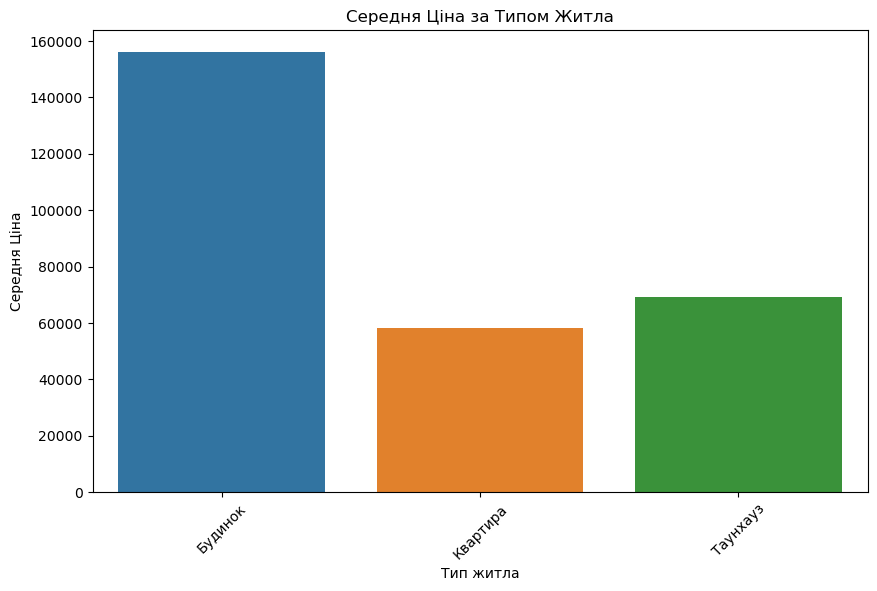

In [12]:
# Групування даних за типом житла і обчислення середньої ціни
grouped_data = df.groupby('Тип житла')['Вартість'].mean().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(10, 6))
sns.barplot(x='Тип житла', y='Вартість', data=grouped_data)
plt.xlabel('Тип житла')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла')
plt.xticks(rotation=45)  
# Обертання підписів по вісі X для кращої читабельності
plt.show()


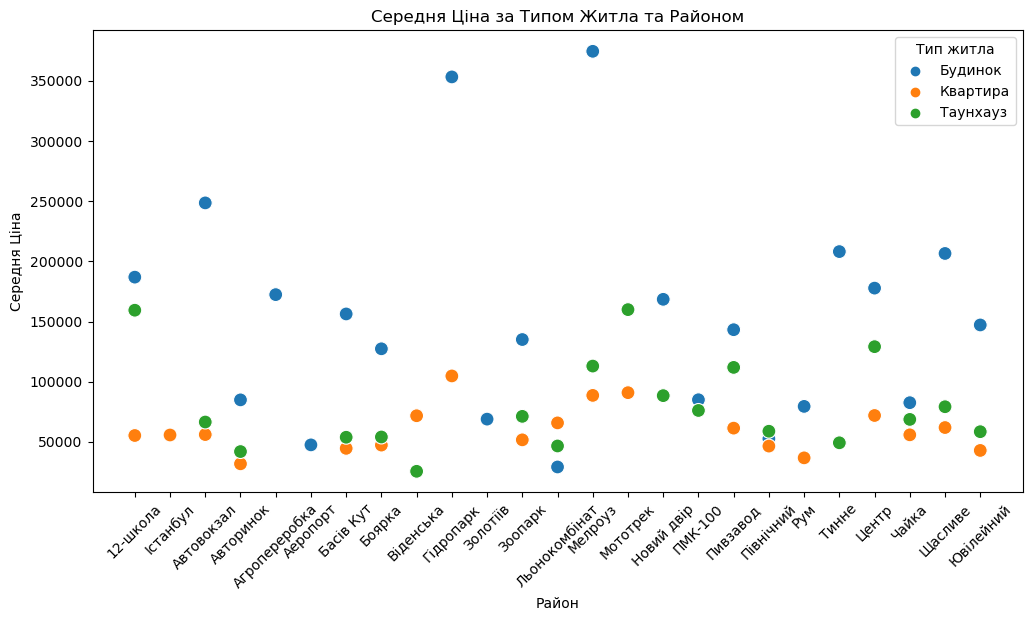

In [13]:
# Групування даних за районом і типом житла і обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Район', y='Вартість', hue='Тип житла', data=grouped_data, s=100)
plt.xlabel('Район')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()

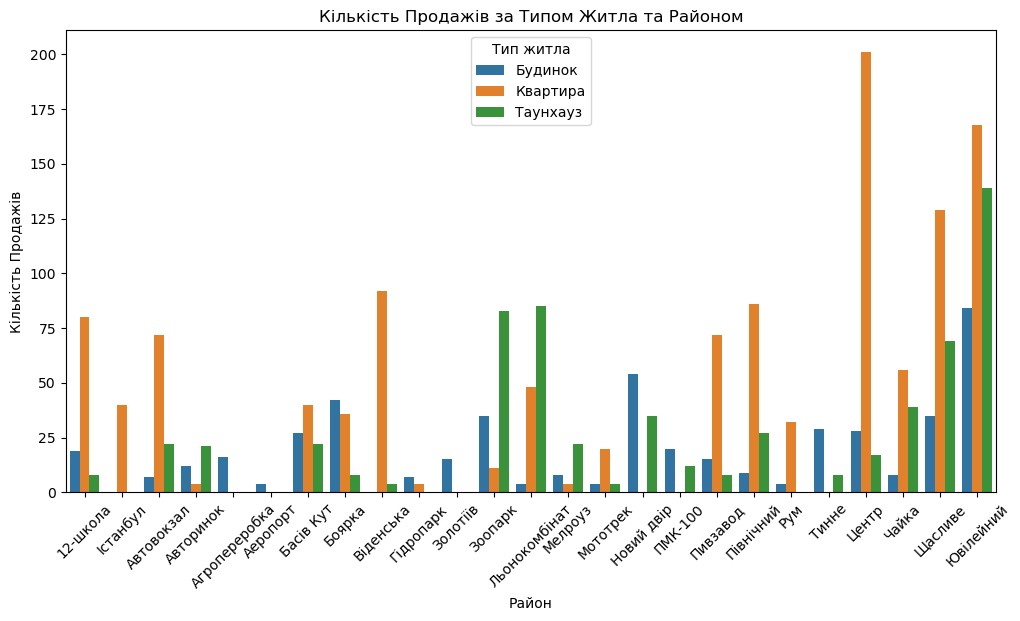

In [14]:
# Групування даних за районом і типом житла і підрахунок кількості виставлених на продажу об'єктів
count_data = df.groupby(['Район', 'Тип житла'])['Вартість'].count().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(12, 6))
sns.barplot(x='Район', y='Вартість', hue='Тип житла', data=count_data)
plt.xlabel('Район')
plt.ylabel('Кількість Продажів')
plt.title('Кількість Продажів за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()


In [15]:
# Замінюю категоріальні значення типу житла на числові
df['Тип житла'] = df['Тип житла'].replace({'Квартира': 1, 'Таунхауз': 2, 'Будинок': 3})

# Перегляньте оновлений датасет
df.head()

,Район,Тип житла,Загальна площа (м²),Кількість кімнат,Ціна в $/м²,Земельний участок (соток),Вартість
0,12-школа,3,59,3,1644,4,96996
1,12-школа,3,90,2,1500,6,135000
2,12-школа,2,151,3,1656,4,250056
3,12-школа,3,240,4,1417,7,340080
4,12-школа,3,90,2,1500,6,135000


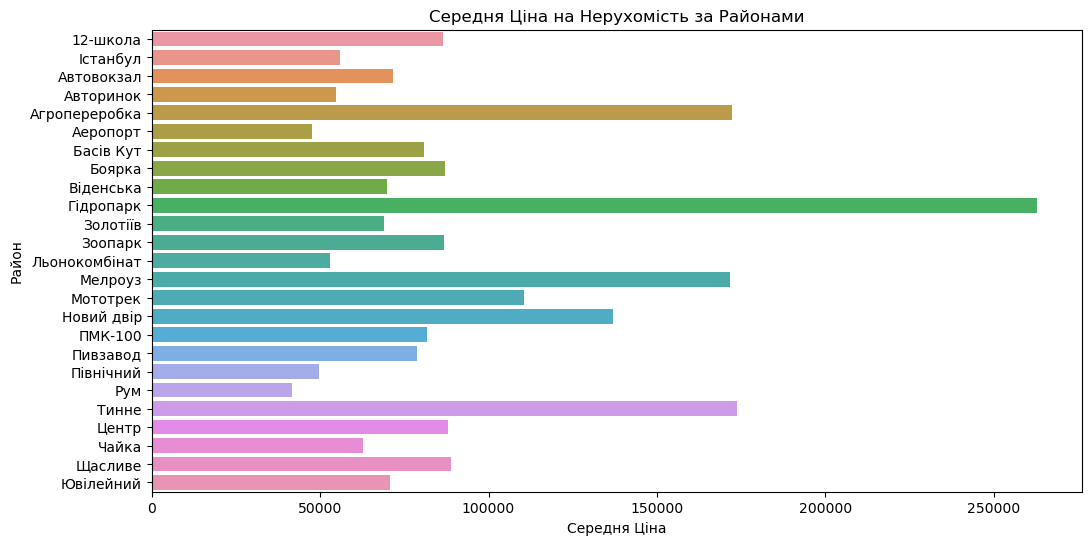

In [16]:
# Групування даних за районом і обчислення середньої ціни
grouped_data = df.groupby('Район')['Вартість'].mean().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(12, 6))
sns.barplot(x='Вартість', y='Район', data=grouped_data, orient='h')
plt.xlabel('Середня Ціна')
plt.ylabel('Район')
plt.title('Середня Ціна на Нерухомість за Районами')
plt.show()


In [17]:
# Переводимо категоріальні ознаки стовпчика "Район" треба перевести в числовий формат. 
# Для цього використовуємо One-Hot Encoding
df = pd.get_dummies(df, columns=['Район'])

In [19]:
# тепер пробуємо створити та навчати модель машиного навчання для задачі регресії та подивимось на результати

# Розділення даних на ознаки (X) і цільову змінну (y)
X = df.drop('Вартість', axis=1)  # Вилучення цільової змінної
y = df['Вартість']

# Розділення даних на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Пробуємо створити модель лінійної регресії
model = LinearRegression()

# Тренування моделі на навчальних даних
model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
accuracy = model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Linear Regression: {accuracy}')

y_pred_linear = model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error (MSE) of Linear Regression: {mse_linear}')


Accuracy (R-squared) of Linear Regression: 0.9040509308037916
Mean Squared Error (MSE) of Linear Regression: 616820345.9598919


In [21]:
# Пробуємо використовувати ансамблі, створимо модель випадкового лісу
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Тренування моделі на навчальних даних
rf_model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
rf_accuracy = rf_model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Random Forest: {rf_accuracy}')

y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error (MSE) of Random Forest: {mse_rf}')

Accuracy (R-squared) of Random Forest: 0.99799432861636
Mean Squared Error (MSE) of Random Forest: 12893704.202683162


In [22]:
# Тепер пробуємо градієнтний бустинг:

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)

# Тренування моделі на навчальних даних
gb_model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
gb_accuracy = gb_model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Gradient Boosting: {gb_accuracy}')

y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f'Mean Squared Error (MSE) of Gradient Boosting: {mse_gb}')

Accuracy (R-squared) of Gradient Boosting: 0.9922396508956985
Mean Squared Error (MSE) of Gradient Boosting: 49888354.93022085


In [6]:
# тепер пробуємо створити та навчати модель нейроної мережі для задачі регресії та подивимось на результати

In [23]:
# Стандартизація ознак
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
# Створення та компіляція (модель створена за допомогою класу Sequential тобто шари попорядку)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Один нейрон в вихідному шарі для регресії
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
# Навчання моделі (я підберав різну кількість епох, найкращі результати при 10 тис. так й )
model.fit(X_train, y_train, epochs=10000, batch_size=32, validation_split=0.2)

# Оцінка моделі на тестових даних
y_pred = model.predict(X_test)

Epoch 1/10000
47/47 [==============================] - 0s 2ms/step - loss: 13440463872.0000 - val_loss: 8740114432.0000
Epoch 2/10000
47/47 [==============================] - 0s 866us/step - loss: 13438960640.0000 - val_loss: 8738147328.0000
Epoch 3/10000
47/47 [==============================] - 0s 869us/step - loss: 13434982400.0000 - val_loss: 8733121536.0000
Epoch 4/10000
47/47 [==============================] - 0s 822us/step - loss: 13425639424.0000 - val_loss: 8722363392.0000
Epoch 5/10000
47/47 [==============================] - 0s 845us/step - loss: 13406907392.0000 - val_loss: 8703466496.0000
Epoch 6/10000
47/47 [==============================] - 0s 826us/step - loss: 13375590400.0000 - val_loss: 8672978944.0000
Epoch 7/10000
47/47 [==============================] - 0s 821us/step - loss: 13327534080.0000 - val_loss: 8629414912.0000
Epoch 8/10000
47/47 [==============================] - 0s 821us/step - loss: 13260162048.0000 - val_loss: 8568362496.0000
Epoch 9/10000
47/47 [=====

47/47 [==============================] - 0s 781us/step - loss: 1367554432.0000 - val_loss: 917174848.0000
Epoch 69/10000
47/47 [==============================] - 0s 828us/step - loss: 1341132288.0000 - val_loss: 902410816.0000
Epoch 70/10000
47/47 [==============================] - 0s 792us/step - loss: 1315263360.0000 - val_loss: 890119168.0000
Epoch 71/10000
47/47 [==============================] - 0s 790us/step - loss: 1290849280.0000 - val_loss: 872884160.0000
Epoch 72/10000
47/47 [==============================] - 0s 808us/step - loss: 1267241088.0000 - val_loss: 859308672.0000
Epoch 73/10000
47/47 [==============================] - 0s 809us/step - loss: 1242619008.0000 - val_loss: 855283904.0000
Epoch 74/10000
47/47 [==============================] - 0s 798us/step - loss: 1220058368.0000 - val_loss: 845418432.0000
Epoch 75/10000
47/47 [==============================] - 0s 806us/step - loss: 1198280704.0000 - val_loss: 841588480.0000
Epoch 76/10000
47/47 [=========================

Epoch 136/10000
47/47 [==============================] - 0s 815us/step - loss: 534447680.0000 - val_loss: 535327552.0000
Epoch 137/10000
47/47 [==============================] - 0s 805us/step - loss: 529608384.0000 - val_loss: 531608064.0000
Epoch 138/10000
47/47 [==============================] - 0s 805us/step - loss: 525590560.0000 - val_loss: 530206368.0000
Epoch 139/10000
47/47 [==============================] - 0s 796us/step - loss: 521586720.0000 - val_loss: 530450976.0000
Epoch 140/10000
47/47 [==============================] - 0s 808us/step - loss: 516845536.0000 - val_loss: 537946240.0000
Epoch 141/10000
47/47 [==============================] - 0s 792us/step - loss: 512992640.0000 - val_loss: 531182048.0000
Epoch 142/10000
47/47 [==============================] - 0s 794us/step - loss: 510048448.0000 - val_loss: 533958304.0000
Epoch 143/10000
47/47 [==============================] - 0s 794us/step - loss: 505780928.0000 - val_loss: 528739360.0000
Epoch 144/10000
47/47 [=========

47/47 [==============================] - 0s 797us/step - loss: 365301664.0000 - val_loss: 452608192.0000
Epoch 204/10000
47/47 [==============================] - 0s 763us/step - loss: 362032480.0000 - val_loss: 449436800.0000
Epoch 205/10000
47/47 [==============================] - 0s 822us/step - loss: 361418048.0000 - val_loss: 451537472.0000
Epoch 206/10000
47/47 [==============================] - 0s 816us/step - loss: 358568544.0000 - val_loss: 445123168.0000
Epoch 207/10000
47/47 [==============================] - 0s 803us/step - loss: 356638752.0000 - val_loss: 444813088.0000
Epoch 208/10000
47/47 [==============================] - 0s 795us/step - loss: 354933024.0000 - val_loss: 446399040.0000
Epoch 209/10000
47/47 [==============================] - 0s 811us/step - loss: 353106336.0000 - val_loss: 445098304.0000
Epoch 210/10000
47/47 [==============================] - 0s 788us/step - loss: 351397024.0000 - val_loss: 441852224.0000
Epoch 211/10000
47/47 [=========================

Epoch 271/10000
47/47 [==============================] - 0s 809us/step - loss: 257314928.0000 - val_loss: 344968640.0000
Epoch 272/10000
47/47 [==============================] - 0s 793us/step - loss: 256045216.0000 - val_loss: 345182976.0000
Epoch 273/10000
47/47 [==============================] - 0s 803us/step - loss: 255050064.0000 - val_loss: 344444416.0000
Epoch 274/10000
47/47 [==============================] - 0s 788us/step - loss: 254617328.0000 - val_loss: 340079840.0000
Epoch 275/10000
47/47 [==============================] - 0s 804us/step - loss: 252688400.0000 - val_loss: 341838656.0000
Epoch 276/10000
47/47 [==============================] - 0s 810us/step - loss: 251642496.0000 - val_loss: 340801984.0000
Epoch 277/10000
47/47 [==============================] - 0s 774us/step - loss: 250472704.0000 - val_loss: 334636608.0000
Epoch 278/10000
47/47 [==============================] - 0s 794us/step - loss: 249566336.0000 - val_loss: 337252032.0000
Epoch 279/10000
47/47 [=========

47/47 [==============================] - 0s 793us/step - loss: 200465568.0000 - val_loss: 279855104.0000
Epoch 339/10000
47/47 [==============================] - 0s 824us/step - loss: 199744576.0000 - val_loss: 279010560.0000
Epoch 340/10000
47/47 [==============================] - 0s 809us/step - loss: 199058112.0000 - val_loss: 281140864.0000
Epoch 341/10000
47/47 [==============================] - 0s 821us/step - loss: 199012752.0000 - val_loss: 279961472.0000
Epoch 342/10000
47/47 [==============================] - 0s 807us/step - loss: 198090560.0000 - val_loss: 279487584.0000
Epoch 343/10000
47/47 [==============================] - 0s 809us/step - loss: 197262032.0000 - val_loss: 278212928.0000
Epoch 344/10000
47/47 [==============================] - 0s 804us/step - loss: 197049920.0000 - val_loss: 277608896.0000
Epoch 345/10000
47/47 [==============================] - 0s 794us/step - loss: 196719584.0000 - val_loss: 275278944.0000
Epoch 346/10000
47/47 [=========================

Epoch 406/10000
47/47 [==============================] - 0s 811us/step - loss: 164922512.0000 - val_loss: 245889504.0000
Epoch 407/10000
47/47 [==============================] - 0s 808us/step - loss: 164611472.0000 - val_loss: 248134288.0000
Epoch 408/10000
47/47 [==============================] - 0s 799us/step - loss: 164353776.0000 - val_loss: 244142176.0000
Epoch 409/10000
47/47 [==============================] - 0s 819us/step - loss: 163569424.0000 - val_loss: 244849856.0000
Epoch 410/10000
47/47 [==============================] - 0s 808us/step - loss: 163461200.0000 - val_loss: 243803776.0000
Epoch 411/10000
47/47 [==============================] - 0s 808us/step - loss: 163430480.0000 - val_loss: 245834544.0000
Epoch 412/10000
47/47 [==============================] - 0s 778us/step - loss: 162328720.0000 - val_loss: 241643472.0000
Epoch 413/10000
47/47 [==============================] - 0s 805us/step - loss: 162759008.0000 - val_loss: 241984128.0000
Epoch 414/10000
47/47 [=========

47/47 [==============================] - 0s 797us/step - loss: 139871584.0000 - val_loss: 219069376.0000
Epoch 474/10000
47/47 [==============================] - 0s 806us/step - loss: 139196320.0000 - val_loss: 218237744.0000
Epoch 475/10000
47/47 [==============================] - 0s 812us/step - loss: 138906768.0000 - val_loss: 219094704.0000
Epoch 476/10000
47/47 [==============================] - 0s 803us/step - loss: 138960240.0000 - val_loss: 217962448.0000
Epoch 477/10000
47/47 [==============================] - 0s 819us/step - loss: 139016144.0000 - val_loss: 218476960.0000
Epoch 478/10000
47/47 [==============================] - 0s 822us/step - loss: 138446064.0000 - val_loss: 215870752.0000
Epoch 479/10000
47/47 [==============================] - 0s 791us/step - loss: 138317152.0000 - val_loss: 217696512.0000
Epoch 480/10000
47/47 [==============================] - 0s 822us/step - loss: 137530416.0000 - val_loss: 215159328.0000
Epoch 481/10000
47/47 [=========================

Epoch 541/10000
47/47 [==============================] - 0s 779us/step - loss: 120026912.0000 - val_loss: 196911936.0000
Epoch 542/10000
47/47 [==============================] - 0s 804us/step - loss: 119919664.0000 - val_loss: 194661392.0000
Epoch 543/10000
47/47 [==============================] - 0s 828us/step - loss: 119424728.0000 - val_loss: 195428176.0000
Epoch 544/10000
47/47 [==============================] - 0s 817us/step - loss: 119406784.0000 - val_loss: 195468656.0000
Epoch 545/10000
47/47 [==============================] - 0s 807us/step - loss: 119264568.0000 - val_loss: 196748656.0000
Epoch 546/10000
47/47 [==============================] - 0s 824us/step - loss: 118962464.0000 - val_loss: 194990336.0000
Epoch 547/10000
47/47 [==============================] - 0s 800us/step - loss: 118718064.0000 - val_loss: 195386832.0000
Epoch 548/10000
47/47 [==============================] - 0s 790us/step - loss: 118299576.0000 - val_loss: 195346592.0000
Epoch 549/10000
47/47 [=========

47/47 [==============================] - 0s 786us/step - loss: 105693392.0000 - val_loss: 179447152.0000
Epoch 609/10000
47/47 [==============================] - 0s 829us/step - loss: 105540256.0000 - val_loss: 180852224.0000
Epoch 610/10000
47/47 [==============================] - 0s 823us/step - loss: 105217736.0000 - val_loss: 179273472.0000
Epoch 611/10000
47/47 [==============================] - 0s 811us/step - loss: 104921424.0000 - val_loss: 178988848.0000
Epoch 612/10000
47/47 [==============================] - 0s 808us/step - loss: 104862424.0000 - val_loss: 179500768.0000
Epoch 613/10000
47/47 [==============================] - 0s 788us/step - loss: 104557736.0000 - val_loss: 178542080.0000
Epoch 614/10000
47/47 [==============================] - 0s 819us/step - loss: 104456528.0000 - val_loss: 177785248.0000
Epoch 615/10000
47/47 [==============================] - 0s 807us/step - loss: 104403144.0000 - val_loss: 177023344.0000
Epoch 616/10000
47/47 [=========================

47/47 [==============================] - 0s 810us/step - loss: 93646336.0000 - val_loss: 164744096.0000
Epoch 677/10000
47/47 [==============================] - 0s 805us/step - loss: 93538368.0000 - val_loss: 165377344.0000
Epoch 678/10000
47/47 [==============================] - 0s 804us/step - loss: 93223528.0000 - val_loss: 164256672.0000
Epoch 679/10000
47/47 [==============================] - 0s 785us/step - loss: 93179768.0000 - val_loss: 163065456.0000
Epoch 680/10000
47/47 [==============================] - 0s 802us/step - loss: 93020208.0000 - val_loss: 163738752.0000
Epoch 681/10000
47/47 [==============================] - 0s 793us/step - loss: 93020440.0000 - val_loss: 163461568.0000
Epoch 682/10000
47/47 [==============================] - 0s 796us/step - loss: 92740544.0000 - val_loss: 164229104.0000
Epoch 683/10000
47/47 [==============================] - 0s 788us/step - loss: 92659304.0000 - val_loss: 162047104.0000
Epoch 684/10000
47/47 [==============================] -

47/47 [==============================] - 0s 809us/step - loss: 83460640.0000 - val_loss: 150537392.0000
Epoch 745/10000
47/47 [==============================] - 0s 781us/step - loss: 83243952.0000 - val_loss: 148894624.0000
Epoch 746/10000
47/47 [==============================] - 0s 781us/step - loss: 83208464.0000 - val_loss: 149652784.0000
Epoch 747/10000
47/47 [==============================] - 0s 817us/step - loss: 83070408.0000 - val_loss: 149064608.0000
Epoch 748/10000
47/47 [==============================] - 0s 783us/step - loss: 83028480.0000 - val_loss: 149480768.0000
Epoch 749/10000
47/47 [==============================] - 0s 811us/step - loss: 82916680.0000 - val_loss: 148093712.0000
Epoch 750/10000
47/47 [==============================] - 0s 790us/step - loss: 82574152.0000 - val_loss: 149202272.0000
Epoch 751/10000
47/47 [==============================] - 0s 819us/step - loss: 82753816.0000 - val_loss: 148314784.0000
Epoch 752/10000
47/47 [==============================] -

47/47 [==============================] - 0s 839us/step - loss: 74607592.0000 - val_loss: 135505456.0000
Epoch 813/10000
47/47 [==============================] - 0s 795us/step - loss: 74520032.0000 - val_loss: 135870256.0000
Epoch 814/10000
47/47 [==============================] - 0s 794us/step - loss: 74378088.0000 - val_loss: 136302144.0000
Epoch 815/10000
47/47 [==============================] - 0s 809us/step - loss: 74442960.0000 - val_loss: 135936960.0000
Epoch 816/10000
47/47 [==============================] - 0s 828us/step - loss: 74085408.0000 - val_loss: 136023472.0000
Epoch 817/10000
47/47 [==============================] - 0s 808us/step - loss: 74016168.0000 - val_loss: 136600160.0000
Epoch 818/10000
47/47 [==============================] - 0s 795us/step - loss: 73916200.0000 - val_loss: 136646688.0000
Epoch 819/10000
47/47 [==============================] - 0s 822us/step - loss: 74020120.0000 - val_loss: 136339184.0000
Epoch 820/10000
47/47 [==============================] -

47/47 [==============================] - 0s 806us/step - loss: 65576556.0000 - val_loss: 125967568.0000
Epoch 881/10000
47/47 [==============================] - 0s 818us/step - loss: 65444316.0000 - val_loss: 125728928.0000
Epoch 882/10000
47/47 [==============================] - 0s 806us/step - loss: 65384236.0000 - val_loss: 125552216.0000
Epoch 883/10000
47/47 [==============================] - 0s 815us/step - loss: 65084888.0000 - val_loss: 124835600.0000
Epoch 884/10000
47/47 [==============================] - 0s 815us/step - loss: 65122848.0000 - val_loss: 125128216.0000
Epoch 885/10000
47/47 [==============================] - 0s 798us/step - loss: 65120864.0000 - val_loss: 125644136.0000
Epoch 886/10000
47/47 [==============================] - 0s 817us/step - loss: 64711116.0000 - val_loss: 123506544.0000
Epoch 887/10000
47/47 [==============================] - 0s 799us/step - loss: 64457180.0000 - val_loss: 124874472.0000
Epoch 888/10000
47/47 [==============================] -

47/47 [==============================] - 0s 807us/step - loss: 55707528.0000 - val_loss: 110178400.0000
Epoch 949/10000
47/47 [==============================] - 0s 815us/step - loss: 55632980.0000 - val_loss: 110970496.0000
Epoch 950/10000
47/47 [==============================] - 0s 789us/step - loss: 55343044.0000 - val_loss: 110386216.0000
Epoch 951/10000
47/47 [==============================] - 0s 795us/step - loss: 55063340.0000 - val_loss: 111287400.0000
Epoch 952/10000
47/47 [==============================] - 0s 818us/step - loss: 54918072.0000 - val_loss: 109741536.0000
Epoch 953/10000
47/47 [==============================] - 0s 781us/step - loss: 54799644.0000 - val_loss: 110346424.0000
Epoch 954/10000
47/47 [==============================] - 0s 784us/step - loss: 54646456.0000 - val_loss: 110437872.0000
Epoch 955/10000
47/47 [==============================] - 0s 804us/step - loss: 54389092.0000 - val_loss: 108767328.0000
Epoch 956/10000
47/47 [==============================] -

47/47 [==============================] - 0s 802us/step - loss: 43677764.0000 - val_loss: 94195544.0000
Epoch 1017/10000
47/47 [==============================] - 0s 820us/step - loss: 43479668.0000 - val_loss: 92631744.0000
Epoch 1018/10000
47/47 [==============================] - 0s 808us/step - loss: 43270108.0000 - val_loss: 92307640.0000
Epoch 1019/10000
47/47 [==============================] - 0s 815us/step - loss: 43095556.0000 - val_loss: 91595920.0000
Epoch 1020/10000
47/47 [==============================] - 0s 807us/step - loss: 42793996.0000 - val_loss: 91938776.0000
Epoch 1021/10000
47/47 [==============================] - 0s 798us/step - loss: 42563080.0000 - val_loss: 90743056.0000
Epoch 1022/10000
47/47 [==============================] - 0s 824us/step - loss: 42508092.0000 - val_loss: 90963688.0000
Epoch 1023/10000
47/47 [==============================] - 0s 782us/step - loss: 42252400.0000 - val_loss: 91056120.0000
Epoch 1024/10000
47/47 [==============================] -

47/47 [==============================] - 0s 778us/step - loss: 30178782.0000 - val_loss: 71427824.0000
Epoch 1085/10000
47/47 [==============================] - 0s 790us/step - loss: 29902662.0000 - val_loss: 71179160.0000
Epoch 1086/10000
47/47 [==============================] - 0s 812us/step - loss: 29701580.0000 - val_loss: 70647432.0000
Epoch 1087/10000
47/47 [==============================] - 0s 817us/step - loss: 29673998.0000 - val_loss: 70086576.0000
Epoch 1088/10000
47/47 [==============================] - 0s 808us/step - loss: 29475272.0000 - val_loss: 70190096.0000
Epoch 1089/10000
47/47 [==============================] - 0s 797us/step - loss: 29239132.0000 - val_loss: 70918568.0000
Epoch 1090/10000
47/47 [==============================] - 0s 775us/step - loss: 28999880.0000 - val_loss: 69524856.0000
Epoch 1091/10000
47/47 [==============================] - 0s 810us/step - loss: 28792642.0000 - val_loss: 68690960.0000
Epoch 1092/10000
47/47 [==============================] -

47/47 [==============================] - 0s 793us/step - loss: 19588292.0000 - val_loss: 51786792.0000
Epoch 1153/10000
47/47 [==============================] - 0s 779us/step - loss: 19535628.0000 - val_loss: 51509476.0000
Epoch 1154/10000
47/47 [==============================] - 0s 808us/step - loss: 19482232.0000 - val_loss: 51280020.0000
Epoch 1155/10000
47/47 [==============================] - 0s 780us/step - loss: 19289632.0000 - val_loss: 51143676.0000
Epoch 1156/10000
47/47 [==============================] - 0s 777us/step - loss: 19140028.0000 - val_loss: 51350264.0000
Epoch 1157/10000
47/47 [==============================] - 0s 804us/step - loss: 19051176.0000 - val_loss: 50465112.0000
Epoch 1158/10000
47/47 [==============================] - 0s 834us/step - loss: 18906338.0000 - val_loss: 50799844.0000
Epoch 1159/10000
47/47 [==============================] - 0s 801us/step - loss: 18854638.0000 - val_loss: 50432068.0000
Epoch 1160/10000
47/47 [==============================] -

47/47 [==============================] - 0s 822us/step - loss: 13791950.0000 - val_loss: 38260960.0000
Epoch 1221/10000
47/47 [==============================] - 0s 795us/step - loss: 13653713.0000 - val_loss: 38397660.0000
Epoch 1222/10000
47/47 [==============================] - 0s 793us/step - loss: 13518535.0000 - val_loss: 37258076.0000
Epoch 1223/10000
47/47 [==============================] - 0s 809us/step - loss: 13557245.0000 - val_loss: 37195592.0000
Epoch 1224/10000
47/47 [==============================] - 0s 804us/step - loss: 13571093.0000 - val_loss: 38341608.0000
Epoch 1225/10000
47/47 [==============================] - 0s 788us/step - loss: 13330655.0000 - val_loss: 37944040.0000
Epoch 1226/10000
47/47 [==============================] - 0s 824us/step - loss: 13279730.0000 - val_loss: 37460788.0000
Epoch 1227/10000
47/47 [==============================] - 0s 782us/step - loss: 13226388.0000 - val_loss: 36387840.0000
Epoch 1228/10000
47/47 [==============================] -

47/47 [==============================] - 0s 806us/step - loss: 9961776.0000 - val_loss: 28463284.0000
Epoch 1289/10000
47/47 [==============================] - 0s 783us/step - loss: 9826338.0000 - val_loss: 28361830.0000
Epoch 1290/10000
47/47 [==============================] - 0s 789us/step - loss: 9796573.0000 - val_loss: 28881194.0000
Epoch 1291/10000
47/47 [==============================] - 0s 781us/step - loss: 9773319.0000 - val_loss: 28535428.0000
Epoch 1292/10000
47/47 [==============================] - 0s 803us/step - loss: 9723593.0000 - val_loss: 27844712.0000
Epoch 1293/10000
47/47 [==============================] - 0s 799us/step - loss: 9662663.0000 - val_loss: 28673032.0000
Epoch 1294/10000
47/47 [==============================] - 0s 799us/step - loss: 9749572.0000 - val_loss: 28053314.0000
Epoch 1295/10000
47/47 [==============================] - 0s 812us/step - loss: 9649226.0000 - val_loss: 27870588.0000
Epoch 1296/10000
47/47 [==============================] - 0s 800u

Epoch 1357/10000
47/47 [==============================] - 0s 792us/step - loss: 7625747.5000 - val_loss: 22888128.0000
Epoch 1358/10000
47/47 [==============================] - 0s 818us/step - loss: 7545564.5000 - val_loss: 22641208.0000
Epoch 1359/10000
47/47 [==============================] - 0s 811us/step - loss: 7548731.5000 - val_loss: 22072742.0000
Epoch 1360/10000
47/47 [==============================] - 0s 785us/step - loss: 7571521.0000 - val_loss: 22096218.0000
Epoch 1361/10000
47/47 [==============================] - 0s 788us/step - loss: 7511046.0000 - val_loss: 23054222.0000
Epoch 1362/10000
47/47 [==============================] - 0s 825us/step - loss: 7475955.0000 - val_loss: 22866518.0000
Epoch 1363/10000
47/47 [==============================] - 0s 804us/step - loss: 7526106.0000 - val_loss: 23389774.0000
Epoch 1364/10000
47/47 [==============================] - 0s 795us/step - loss: 7542770.0000 - val_loss: 22006180.0000
Epoch 1365/10000
47/47 [========================

Epoch 1426/10000
47/47 [==============================] - 0s 814us/step - loss: 5868532.0000 - val_loss: 18267676.0000
Epoch 1427/10000
47/47 [==============================] - 0s 788us/step - loss: 5802510.5000 - val_loss: 17897366.0000
Epoch 1428/10000
47/47 [==============================] - 0s 825us/step - loss: 5843208.5000 - val_loss: 18354644.0000
Epoch 1429/10000
47/47 [==============================] - 0s 790us/step - loss: 5874990.5000 - val_loss: 18055638.0000
Epoch 1430/10000
47/47 [==============================] - 0s 822us/step - loss: 5752029.0000 - val_loss: 18120426.0000
Epoch 1431/10000
47/47 [==============================] - 0s 818us/step - loss: 5802662.0000 - val_loss: 18068468.0000
Epoch 1432/10000
47/47 [==============================] - 0s 793us/step - loss: 5776271.0000 - val_loss: 17328098.0000
Epoch 1433/10000
47/47 [==============================] - 0s 809us/step - loss: 5771063.5000 - val_loss: 18439132.0000
Epoch 1434/10000
47/47 [========================

Epoch 1495/10000
47/47 [==============================] - 0s 800us/step - loss: 4695056.5000 - val_loss: 15198211.0000
Epoch 1496/10000
47/47 [==============================] - 0s 811us/step - loss: 4690239.5000 - val_loss: 15070049.0000
Epoch 1497/10000
47/47 [==============================] - 0s 807us/step - loss: 4774077.5000 - val_loss: 15202263.0000
Epoch 1498/10000
47/47 [==============================] - 0s 807us/step - loss: 4680115.0000 - val_loss: 15070064.0000
Epoch 1499/10000
47/47 [==============================] - 0s 774us/step - loss: 4595617.5000 - val_loss: 15350823.0000
Epoch 1500/10000
47/47 [==============================] - 0s 776us/step - loss: 4724417.0000 - val_loss: 15020254.0000
Epoch 1501/10000
47/47 [==============================] - 0s 795us/step - loss: 4592950.5000 - val_loss: 15873646.0000
Epoch 1502/10000
47/47 [==============================] - 0s 805us/step - loss: 4664276.0000 - val_loss: 15200818.0000
Epoch 1503/10000
47/47 [========================

Epoch 1564/10000
47/47 [==============================] - 0s 813us/step - loss: 3792408.5000 - val_loss: 12603745.0000
Epoch 1565/10000
47/47 [==============================] - 0s 802us/step - loss: 3775046.0000 - val_loss: 12692557.0000
Epoch 1566/10000
47/47 [==============================] - 0s 805us/step - loss: 3729204.5000 - val_loss: 12895358.0000
Epoch 1567/10000
47/47 [==============================] - 0s 802us/step - loss: 3711252.5000 - val_loss: 13466617.0000
Epoch 1568/10000
47/47 [==============================] - 0s 817us/step - loss: 3686592.0000 - val_loss: 13138531.0000
Epoch 1569/10000
47/47 [==============================] - 0s 799us/step - loss: 3714259.2500 - val_loss: 12483601.0000
Epoch 1570/10000
47/47 [==============================] - 0s 795us/step - loss: 3746321.2500 - val_loss: 12993147.0000
Epoch 1571/10000
47/47 [==============================] - 0s 813us/step - loss: 3682610.7500 - val_loss: 12371118.0000
Epoch 1572/10000
47/47 [========================

Epoch 1633/10000
47/47 [==============================] - 0s 578us/step - loss: 3133158.0000 - val_loss: 11545344.0000
Epoch 1634/10000
47/47 [==============================] - 0s 575us/step - loss: 3016863.2500 - val_loss: 11258891.0000
Epoch 1635/10000
47/47 [==============================] - 0s 591us/step - loss: 3013458.7500 - val_loss: 11329205.0000
Epoch 1636/10000
47/47 [==============================] - 0s 600us/step - loss: 3023078.0000 - val_loss: 10857973.0000
Epoch 1637/10000
47/47 [==============================] - 0s 608us/step - loss: 2934227.7500 - val_loss: 11456261.0000
Epoch 1638/10000
47/47 [==============================] - 0s 613us/step - loss: 2979438.2500 - val_loss: 11113271.0000
Epoch 1639/10000
47/47 [==============================] - 0s 628us/step - loss: 3039102.2500 - val_loss: 11335925.0000
Epoch 1640/10000
47/47 [==============================] - 0s 585us/step - loss: 2996842.5000 - val_loss: 11257784.0000
Epoch 1641/10000
47/47 [========================

Epoch 1702/10000
47/47 [==============================] - 0s 595us/step - loss: 2494189.2500 - val_loss: 9974745.0000
Epoch 1703/10000
47/47 [==============================] - 0s 596us/step - loss: 2451128.7500 - val_loss: 9796342.0000
Epoch 1704/10000
47/47 [==============================] - 0s 587us/step - loss: 2466659.7500 - val_loss: 10002509.0000
Epoch 1705/10000
47/47 [==============================] - 0s 587us/step - loss: 2480494.7500 - val_loss: 9444881.0000
Epoch 1706/10000
47/47 [==============================] - 0s 590us/step - loss: 2474969.0000 - val_loss: 9534136.0000
Epoch 1707/10000
47/47 [==============================] - 0s 604us/step - loss: 2501992.0000 - val_loss: 9419846.0000
Epoch 1708/10000
47/47 [==============================] - 0s 578us/step - loss: 2468907.2500 - val_loss: 9951300.0000
Epoch 1709/10000
47/47 [==============================] - 0s 593us/step - loss: 2426126.7500 - val_loss: 9483263.0000
Epoch 1710/10000
47/47 [==============================]

47/47 [==============================] - 0s 596us/step - loss: 2060810.2500 - val_loss: 8524725.0000
Epoch 1772/10000
47/47 [==============================] - 0s 598us/step - loss: 2065594.0000 - val_loss: 8665243.0000
Epoch 1773/10000
47/47 [==============================] - 0s 596us/step - loss: 2046752.0000 - val_loss: 8499549.0000
Epoch 1774/10000
47/47 [==============================] - 0s 589us/step - loss: 2049932.2500 - val_loss: 8900415.0000
Epoch 1775/10000
47/47 [==============================] - 0s 587us/step - loss: 2051889.0000 - val_loss: 8818467.0000
Epoch 1776/10000
47/47 [==============================] - 0s 611us/step - loss: 2068652.5000 - val_loss: 9051445.0000
Epoch 1777/10000
47/47 [==============================] - 0s 599us/step - loss: 2070185.3750 - val_loss: 8717502.0000
Epoch 1778/10000
47/47 [==============================] - 0s 596us/step - loss: 2053910.8750 - val_loss: 8326743.5000
Epoch 1779/10000
47/47 [==============================] - 0s 606us/step -

47/47 [==============================] - 0s 603us/step - loss: 1771668.7500 - val_loss: 8010447.5000
Epoch 1841/10000
47/47 [==============================] - 0s 600us/step - loss: 1762246.7500 - val_loss: 7700812.0000
Epoch 1842/10000
47/47 [==============================] - 0s 576us/step - loss: 1776891.5000 - val_loss: 7792990.5000
Epoch 1843/10000
47/47 [==============================] - 0s 600us/step - loss: 1763544.2500 - val_loss: 7690212.5000
Epoch 1844/10000
47/47 [==============================] - 0s 594us/step - loss: 1761193.1250 - val_loss: 8082608.0000
Epoch 1845/10000
47/47 [==============================] - 0s 605us/step - loss: 1767644.0000 - val_loss: 8124292.5000
Epoch 1846/10000
47/47 [==============================] - 0s 601us/step - loss: 1729201.1250 - val_loss: 7942594.5000
Epoch 1847/10000
47/47 [==============================] - 0s 590us/step - loss: 1723145.6250 - val_loss: 7531707.0000
Epoch 1848/10000
47/47 [==============================] - 0s 600us/step -

47/47 [==============================] - 0s 612us/step - loss: 1599843.0000 - val_loss: 7771250.0000
Epoch 1910/10000
47/47 [==============================] - 0s 618us/step - loss: 1772880.3750 - val_loss: 6741929.0000
Epoch 1911/10000
47/47 [==============================] - 0s 587us/step - loss: 1562205.8750 - val_loss: 6926045.5000
Epoch 1912/10000
47/47 [==============================] - 0s 584us/step - loss: 1488723.5000 - val_loss: 7637727.0000
Epoch 1913/10000
47/47 [==============================] - 0s 591us/step - loss: 1468382.6250 - val_loss: 7018493.0000
Epoch 1914/10000
47/47 [==============================] - 0s 581us/step - loss: 1531354.6250 - val_loss: 7129758.5000
Epoch 1915/10000
47/47 [==============================] - 0s 602us/step - loss: 1485134.1250 - val_loss: 7256110.0000
Epoch 1916/10000
47/47 [==============================] - 0s 620us/step - loss: 1464528.2500 - val_loss: 7262464.0000
Epoch 1917/10000
47/47 [==============================] - 0s 595us/step -

47/47 [==============================] - 0s 601us/step - loss: 1297058.0000 - val_loss: 6702601.0000
Epoch 1979/10000
47/47 [==============================] - 0s 592us/step - loss: 1298151.7500 - val_loss: 6442170.5000
Epoch 1980/10000
47/47 [==============================] - 0s 590us/step - loss: 1295753.5000 - val_loss: 6645823.5000
Epoch 1981/10000
47/47 [==============================] - 0s 583us/step - loss: 1279386.2500 - val_loss: 6723642.0000
Epoch 1982/10000
47/47 [==============================] - 0s 604us/step - loss: 1297596.5000 - val_loss: 6428339.5000
Epoch 1983/10000
47/47 [==============================] - 0s 588us/step - loss: 1283407.6250 - val_loss: 6911907.5000
Epoch 1984/10000
47/47 [==============================] - 0s 582us/step - loss: 1267106.2500 - val_loss: 6426276.0000
Epoch 1985/10000
47/47 [==============================] - 0s 589us/step - loss: 1271980.8750 - val_loss: 6716564.5000
Epoch 1986/10000
47/47 [==============================] - 0s 604us/step -

47/47 [==============================] - 0s 599us/step - loss: 1148641.1250 - val_loss: 6312185.0000
Epoch 2048/10000
47/47 [==============================] - 0s 613us/step - loss: 1171160.0000 - val_loss: 6430235.0000
Epoch 2049/10000
47/47 [==============================] - 0s 588us/step - loss: 1123922.6250 - val_loss: 6381314.0000
Epoch 2050/10000
47/47 [==============================] - 0s 598us/step - loss: 1120419.0000 - val_loss: 6266229.5000
Epoch 2051/10000
47/47 [==============================] - 0s 579us/step - loss: 1138345.5000 - val_loss: 6264865.0000
Epoch 2052/10000
47/47 [==============================] - 0s 592us/step - loss: 1089092.3750 - val_loss: 6497197.0000
Epoch 2053/10000
47/47 [==============================] - 0s 599us/step - loss: 1102479.3750 - val_loss: 6315495.0000
Epoch 2054/10000
47/47 [==============================] - 0s 608us/step - loss: 1101547.8750 - val_loss: 6416374.5000
Epoch 2055/10000
47/47 [==============================] - 0s 580us/step -

47/47 [==============================] - 0s 607us/step - loss: 971120.8750 - val_loss: 5986704.0000
Epoch 2117/10000
47/47 [==============================] - 0s 614us/step - loss: 957382.6875 - val_loss: 6243549.5000
Epoch 2118/10000
47/47 [==============================] - 0s 615us/step - loss: 953823.2500 - val_loss: 6157382.5000
Epoch 2119/10000
47/47 [==============================] - 0s 584us/step - loss: 953771.0625 - val_loss: 6038106.5000
Epoch 2120/10000
47/47 [==============================] - 0s 603us/step - loss: 935540.0625 - val_loss: 6208994.5000
Epoch 2121/10000
47/47 [==============================] - 0s 608us/step - loss: 918177.0625 - val_loss: 6077278.5000
Epoch 2122/10000
47/47 [==============================] - 0s 596us/step - loss: 922268.6875 - val_loss: 6258904.5000
Epoch 2123/10000
47/47 [==============================] - 0s 603us/step - loss: 967320.5625 - val_loss: 5919136.0000
Epoch 2124/10000
47/47 [==============================] - 0s 593us/step - loss: 9

47/47 [==============================] - 0s 602us/step - loss: 778602.4375 - val_loss: 5479571.0000
Epoch 2187/10000
47/47 [==============================] - 0s 597us/step - loss: 794438.2500 - val_loss: 5776203.5000
Epoch 2188/10000
47/47 [==============================] - 0s 588us/step - loss: 779614.9375 - val_loss: 5667625.0000
Epoch 2189/10000
47/47 [==============================] - 0s 607us/step - loss: 793498.1875 - val_loss: 6139810.0000
Epoch 2190/10000
47/47 [==============================] - 0s 600us/step - loss: 774946.2500 - val_loss: 5643957.0000
Epoch 2191/10000
47/47 [==============================] - 0s 607us/step - loss: 777467.7500 - val_loss: 5726203.0000
Epoch 2192/10000
47/47 [==============================] - 0s 586us/step - loss: 762116.0000 - val_loss: 5533583.0000
Epoch 2193/10000
47/47 [==============================] - 0s 595us/step - loss: 775636.4375 - val_loss: 5785617.5000
Epoch 2194/10000
47/47 [==============================] - 0s 608us/step - loss: 7

47/47 [==============================] - 0s 612us/step - loss: 671315.0625 - val_loss: 5414359.5000
Epoch 2257/10000
47/47 [==============================] - 0s 601us/step - loss: 648172.2500 - val_loss: 5760849.5000
Epoch 2258/10000
47/47 [==============================] - 0s 591us/step - loss: 660023.9375 - val_loss: 5496406.5000
Epoch 2259/10000
47/47 [==============================] - 0s 601us/step - loss: 660213.1875 - val_loss: 5586373.5000
Epoch 2260/10000
47/47 [==============================] - 0s 608us/step - loss: 648943.8750 - val_loss: 5603407.5000
Epoch 2261/10000
47/47 [==============================] - 0s 602us/step - loss: 670868.5625 - val_loss: 5619422.0000
Epoch 2262/10000
47/47 [==============================] - 0s 580us/step - loss: 663495.7500 - val_loss: 5322461.0000
Epoch 2263/10000
47/47 [==============================] - 0s 596us/step - loss: 654544.2500 - val_loss: 5428065.5000
Epoch 2264/10000
47/47 [==============================] - 0s 601us/step - loss: 6

47/47 [==============================] - 0s 612us/step - loss: 571001.0000 - val_loss: 5353800.5000
Epoch 2327/10000
47/47 [==============================] - 0s 605us/step - loss: 561357.1250 - val_loss: 5626212.5000
Epoch 2328/10000
47/47 [==============================] - 0s 606us/step - loss: 581742.9375 - val_loss: 5449166.5000
Epoch 2329/10000
47/47 [==============================] - 0s 586us/step - loss: 580510.9375 - val_loss: 5575384.0000
Epoch 2330/10000
47/47 [==============================] - 0s 605us/step - loss: 572768.3750 - val_loss: 5498020.0000
Epoch 2331/10000
47/47 [==============================] - 0s 593us/step - loss: 600546.0000 - val_loss: 5704551.5000
Epoch 2332/10000
47/47 [==============================] - 0s 594us/step - loss: 567422.5625 - val_loss: 5287627.5000
Epoch 2333/10000
47/47 [==============================] - 0s 590us/step - loss: 596125.8125 - val_loss: 5550014.0000
Epoch 2334/10000
47/47 [==============================] - 0s 600us/step - loss: 5

47/47 [==============================] - 0s 608us/step - loss: 514153.1562 - val_loss: 5316560.5000
Epoch 2397/10000
47/47 [==============================] - 0s 615us/step - loss: 509061.0938 - val_loss: 5037081.0000
Epoch 2398/10000
47/47 [==============================] - 0s 595us/step - loss: 497221.4375 - val_loss: 5512299.5000
Epoch 2399/10000
47/47 [==============================] - 0s 601us/step - loss: 511289.7188 - val_loss: 5542683.0000
Epoch 2400/10000
47/47 [==============================] - 0s 606us/step - loss: 495751.4688 - val_loss: 5504423.5000
Epoch 2401/10000
47/47 [==============================] - 0s 590us/step - loss: 519699.9688 - val_loss: 5369989.5000
Epoch 2402/10000
47/47 [==============================] - 0s 571us/step - loss: 522467.9062 - val_loss: 5529478.5000
Epoch 2403/10000
47/47 [==============================] - 0s 585us/step - loss: 495402.8125 - val_loss: 5531139.0000
Epoch 2404/10000
47/47 [==============================] - 0s 587us/step - loss: 5

47/47 [==============================] - 0s 609us/step - loss: 462431.4688 - val_loss: 5318023.5000
Epoch 2467/10000
47/47 [==============================] - 0s 604us/step - loss: 433061.8750 - val_loss: 5554901.0000
Epoch 2468/10000
47/47 [==============================] - 0s 603us/step - loss: 456416.1250 - val_loss: 5425683.5000
Epoch 2469/10000
47/47 [==============================] - 0s 605us/step - loss: 431340.0625 - val_loss: 5531908.0000
Epoch 2470/10000
47/47 [==============================] - 0s 598us/step - loss: 442960.0000 - val_loss: 5022545.0000
Epoch 2471/10000
47/47 [==============================] - 0s 597us/step - loss: 466654.9062 - val_loss: 5179171.0000
Epoch 2472/10000
47/47 [==============================] - 0s 596us/step - loss: 460295.1250 - val_loss: 5231261.0000
Epoch 2473/10000
47/47 [==============================] - 0s 590us/step - loss: 441894.5625 - val_loss: 5708866.0000
Epoch 2474/10000
47/47 [==============================] - 0s 603us/step - loss: 4

47/47 [==============================] - 0s 606us/step - loss: 390746.9688 - val_loss: 5144956.5000
Epoch 2537/10000
47/47 [==============================] - 0s 601us/step - loss: 412743.2188 - val_loss: 5432158.0000
Epoch 2538/10000
47/47 [==============================] - 0s 601us/step - loss: 421479.7500 - val_loss: 5325413.0000
Epoch 2539/10000
47/47 [==============================] - 0s 600us/step - loss: 379670.1250 - val_loss: 5304924.5000
Epoch 2540/10000
47/47 [==============================] - 0s 600us/step - loss: 391029.4062 - val_loss: 5253575.5000
Epoch 2541/10000
47/47 [==============================] - 0s 601us/step - loss: 394745.5938 - val_loss: 5318877.5000
Epoch 2542/10000
47/47 [==============================] - 0s 592us/step - loss: 396131.8438 - val_loss: 5302728.5000
Epoch 2543/10000
47/47 [==============================] - 0s 611us/step - loss: 423343.2188 - val_loss: 5242402.5000
Epoch 2544/10000
47/47 [==============================] - 0s 589us/step - loss: 4

47/47 [==============================] - 0s 604us/step - loss: 354690.7188 - val_loss: 4678326.0000
Epoch 2607/10000
47/47 [==============================] - 0s 608us/step - loss: 354836.0312 - val_loss: 5176236.0000
Epoch 2608/10000
47/47 [==============================] - 0s 597us/step - loss: 348503.5938 - val_loss: 5005610.5000
Epoch 2609/10000
47/47 [==============================] - 0s 596us/step - loss: 349484.0938 - val_loss: 4934686.5000
Epoch 2610/10000
47/47 [==============================] - 0s 601us/step - loss: 346560.5312 - val_loss: 5168592.5000
Epoch 2611/10000
47/47 [==============================] - 0s 588us/step - loss: 381828.4688 - val_loss: 5169246.0000
Epoch 2612/10000
47/47 [==============================] - 0s 589us/step - loss: 350678.5625 - val_loss: 5108275.0000
Epoch 2613/10000
47/47 [==============================] - 0s 591us/step - loss: 336710.6250 - val_loss: 5076185.5000
Epoch 2614/10000
47/47 [==============================] - 0s 597us/step - loss: 3

47/47 [==============================] - 0s 594us/step - loss: 305840.2188 - val_loss: 4676043.5000
Epoch 2677/10000
47/47 [==============================] - 0s 605us/step - loss: 333848.6562 - val_loss: 4813985.0000
Epoch 2678/10000
47/47 [==============================] - 0s 587us/step - loss: 316132.0938 - val_loss: 4788720.0000
Epoch 2679/10000
47/47 [==============================] - 0s 591us/step - loss: 301614.7812 - val_loss: 4738606.0000
Epoch 2680/10000
47/47 [==============================] - 0s 590us/step - loss: 327448.4062 - val_loss: 5011485.0000
Epoch 2681/10000
47/47 [==============================] - 0s 585us/step - loss: 323432.0938 - val_loss: 4761972.5000
Epoch 2682/10000
47/47 [==============================] - 0s 594us/step - loss: 323836.6562 - val_loss: 4537805.5000
Epoch 2683/10000
47/47 [==============================] - 0s 592us/step - loss: 355222.4688 - val_loss: 4903034.0000
Epoch 2684/10000
47/47 [==============================] - 0s 592us/step - loss: 3

47/47 [==============================] - 0s 607us/step - loss: 291321.0000 - val_loss: 4815733.5000
Epoch 2747/10000
47/47 [==============================] - 0s 598us/step - loss: 272787.7188 - val_loss: 4806262.5000
Epoch 2748/10000
47/47 [==============================] - 0s 582us/step - loss: 286082.0938 - val_loss: 4663722.5000
Epoch 2749/10000
47/47 [==============================] - 0s 593us/step - loss: 279322.0938 - val_loss: 4670852.0000
Epoch 2750/10000
47/47 [==============================] - 0s 591us/step - loss: 292654.1250 - val_loss: 4836319.0000
Epoch 2751/10000
47/47 [==============================] - 0s 595us/step - loss: 282573.7812 - val_loss: 4886363.0000
Epoch 2752/10000
47/47 [==============================] - 0s 605us/step - loss: 286787.0625 - val_loss: 4762446.0000
Epoch 2753/10000
47/47 [==============================] - 0s 591us/step - loss: 290817.8438 - val_loss: 4808384.0000
Epoch 2754/10000
47/47 [==============================] - 0s 595us/step - loss: 2

47/47 [==============================] - 0s 611us/step - loss: 268766.2500 - val_loss: 4590417.5000
Epoch 2817/10000
47/47 [==============================] - 0s 605us/step - loss: 280120.0625 - val_loss: 4848603.0000
Epoch 2818/10000
47/47 [==============================] - 0s 589us/step - loss: 263743.5312 - val_loss: 4685395.5000
Epoch 2819/10000
47/47 [==============================] - 0s 612us/step - loss: 257146.7500 - val_loss: 4780497.0000
Epoch 2820/10000
47/47 [==============================] - 0s 587us/step - loss: 242095.0625 - val_loss: 4608964.5000
Epoch 2821/10000
47/47 [==============================] - 0s 598us/step - loss: 247668.8906 - val_loss: 4860479.5000
Epoch 2822/10000
47/47 [==============================] - 0s 615us/step - loss: 251210.8594 - val_loss: 4847250.0000
Epoch 2823/10000
47/47 [==============================] - 0s 598us/step - loss: 257437.9688 - val_loss: 4534679.0000
Epoch 2824/10000
47/47 [==============================] - 0s 602us/step - loss: 2

47/47 [==============================] - 0s 608us/step - loss: 218881.5625 - val_loss: 4667045.5000
Epoch 2887/10000
47/47 [==============================] - 0s 584us/step - loss: 224319.1562 - val_loss: 4442058.5000
Epoch 2888/10000
47/47 [==============================] - 0s 601us/step - loss: 226231.2031 - val_loss: 4835811.5000
Epoch 2889/10000
47/47 [==============================] - 0s 598us/step - loss: 249220.8906 - val_loss: 4492060.0000
Epoch 2890/10000
47/47 [==============================] - 0s 603us/step - loss: 218405.7344 - val_loss: 4426760.0000
Epoch 2891/10000
47/47 [==============================] - 0s 600us/step - loss: 246483.1094 - val_loss: 4912993.0000
Epoch 2892/10000
47/47 [==============================] - 0s 599us/step - loss: 259841.8750 - val_loss: 4519365.5000
Epoch 2893/10000
47/47 [==============================] - 0s 588us/step - loss: 247119.2812 - val_loss: 4940147.0000
Epoch 2894/10000
47/47 [==============================] - 0s 596us/step - loss: 2

47/47 [==============================] - 0s 590us/step - loss: 212542.2969 - val_loss: 4737897.0000
Epoch 2957/10000
47/47 [==============================] - 0s 607us/step - loss: 206893.4844 - val_loss: 4425297.0000
Epoch 2958/10000
47/47 [==============================] - 0s 596us/step - loss: 209962.3125 - val_loss: 4381451.5000
Epoch 2959/10000
47/47 [==============================] - 0s 588us/step - loss: 204702.2031 - val_loss: 4616519.5000
Epoch 2960/10000
47/47 [==============================] - 0s 590us/step - loss: 214825.0625 - val_loss: 4504488.0000
Epoch 2961/10000
47/47 [==============================] - 0s 601us/step - loss: 223188.9688 - val_loss: 4289267.0000
Epoch 2962/10000
47/47 [==============================] - 0s 609us/step - loss: 204590.5938 - val_loss: 4567618.0000
Epoch 2963/10000
47/47 [==============================] - 0s 576us/step - loss: 207334.4688 - val_loss: 4354331.5000
Epoch 2964/10000
47/47 [==============================] - 0s 599us/step - loss: 2

47/47 [==============================] - 0s 594us/step - loss: 180005.6250 - val_loss: 4488861.5000
Epoch 3027/10000
47/47 [==============================] - 0s 599us/step - loss: 193853.1875 - val_loss: 4491949.0000
Epoch 3028/10000
47/47 [==============================] - 0s 577us/step - loss: 198552.0938 - val_loss: 4159605.0000
Epoch 3029/10000
47/47 [==============================] - 0s 608us/step - loss: 190987.5469 - val_loss: 4649014.0000
Epoch 3030/10000
47/47 [==============================] - 0s 602us/step - loss: 200110.5469 - val_loss: 4372112.0000
Epoch 3031/10000
47/47 [==============================] - 0s 620us/step - loss: 185829.0156 - val_loss: 4464852.0000
Epoch 3032/10000
47/47 [==============================] - 0s 586us/step - loss: 199502.5469 - val_loss: 4413602.0000
Epoch 3033/10000
47/47 [==============================] - 0s 596us/step - loss: 192425.5781 - val_loss: 4587176.5000
Epoch 3034/10000
47/47 [==============================] - 0s 608us/step - loss: 1

47/47 [==============================] - 0s 582us/step - loss: 184755.1562 - val_loss: 4335978.5000
Epoch 3097/10000
47/47 [==============================] - 0s 616us/step - loss: 176153.4844 - val_loss: 4321127.0000
Epoch 3098/10000
47/47 [==============================] - 0s 589us/step - loss: 178722.6875 - val_loss: 4406863.5000
Epoch 3099/10000
47/47 [==============================] - 0s 585us/step - loss: 192751.9062 - val_loss: 4462087.0000
Epoch 3100/10000
47/47 [==============================] - 0s 611us/step - loss: 177597.7500 - val_loss: 4071992.5000
Epoch 3101/10000
47/47 [==============================] - 0s 592us/step - loss: 177391.3906 - val_loss: 4182547.0000
Epoch 3102/10000
47/47 [==============================] - 0s 602us/step - loss: 166924.5781 - val_loss: 4289788.0000
Epoch 3103/10000
47/47 [==============================] - 0s 584us/step - loss: 171552.4688 - val_loss: 4239306.5000
Epoch 3104/10000
47/47 [==============================] - 0s 605us/step - loss: 1

47/47 [==============================] - 0s 603us/step - loss: 153213.1406 - val_loss: 4410495.0000
Epoch 3167/10000
47/47 [==============================] - 0s 607us/step - loss: 151475.7031 - val_loss: 4217250.5000
Epoch 3168/10000
47/47 [==============================] - 0s 592us/step - loss: 156408.2500 - val_loss: 4296231.0000
Epoch 3169/10000
47/47 [==============================] - 0s 580us/step - loss: 159217.3438 - val_loss: 4573109.0000
Epoch 3170/10000
47/47 [==============================] - 0s 613us/step - loss: 157990.3594 - val_loss: 4362217.0000
Epoch 3171/10000
47/47 [==============================] - 0s 605us/step - loss: 171842.3281 - val_loss: 4238219.5000
Epoch 3172/10000
47/47 [==============================] - 0s 587us/step - loss: 166328.2188 - val_loss: 4318040.5000
Epoch 3173/10000
47/47 [==============================] - 0s 589us/step - loss: 172872.7500 - val_loss: 4321423.0000
Epoch 3174/10000
47/47 [==============================] - 0s 587us/step - loss: 1

47/47 [==============================] - 0s 594us/step - loss: 143997.1406 - val_loss: 4191952.5000
Epoch 3237/10000
47/47 [==============================] - 0s 599us/step - loss: 143041.0000 - val_loss: 4358104.5000
Epoch 3238/10000
47/47 [==============================] - 0s 593us/step - loss: 155084.5156 - val_loss: 4401716.0000
Epoch 3239/10000
47/47 [==============================] - 0s 602us/step - loss: 145919.0625 - val_loss: 4237254.5000
Epoch 3240/10000
47/47 [==============================] - 0s 590us/step - loss: 149591.8750 - val_loss: 4338033.5000
Epoch 3241/10000
47/47 [==============================] - 0s 605us/step - loss: 151781.0156 - val_loss: 4075011.5000
Epoch 3242/10000
47/47 [==============================] - 0s 607us/step - loss: 152645.4844 - val_loss: 4258705.0000
Epoch 3243/10000
47/47 [==============================] - 0s 599us/step - loss: 141225.7969 - val_loss: 4305011.5000
Epoch 3244/10000
47/47 [==============================] - 0s 579us/step - loss: 1

47/47 [==============================] - 0s 603us/step - loss: 139940.0938 - val_loss: 4373232.0000
Epoch 3307/10000
47/47 [==============================] - 0s 595us/step - loss: 137869.4375 - val_loss: 4029390.0000
Epoch 3308/10000
47/47 [==============================] - 0s 588us/step - loss: 132912.7188 - val_loss: 4059583.5000
Epoch 3309/10000
47/47 [==============================] - 0s 605us/step - loss: 137942.2656 - val_loss: 4057613.0000
Epoch 3310/10000
47/47 [==============================] - 0s 610us/step - loss: 136612.4062 - val_loss: 4237006.0000
Epoch 3311/10000
47/47 [==============================] - 0s 605us/step - loss: 134583.9531 - val_loss: 3906979.5000
Epoch 3312/10000
47/47 [==============================] - 0s 598us/step - loss: 139753.3438 - val_loss: 4208123.0000
Epoch 3313/10000
47/47 [==============================] - 0s 595us/step - loss: 130272.3750 - val_loss: 4150134.7500
Epoch 3314/10000
47/47 [==============================] - 0s 599us/step - loss: 1

47/47 [==============================] - 0s 610us/step - loss: 130479.2422 - val_loss: 4117878.7500
Epoch 3377/10000
47/47 [==============================] - 0s 623us/step - loss: 189864.0625 - val_loss: 3873086.7500
Epoch 3378/10000
47/47 [==============================] - 0s 607us/step - loss: 124066.5312 - val_loss: 4089938.7500
Epoch 3379/10000
47/47 [==============================] - 0s 592us/step - loss: 116813.8594 - val_loss: 3814544.5000
Epoch 3380/10000
47/47 [==============================] - 0s 593us/step - loss: 120104.9922 - val_loss: 4043432.0000
Epoch 3381/10000
47/47 [==============================] - 0s 591us/step - loss: 125670.9375 - val_loss: 3756702.2500
Epoch 3382/10000
47/47 [==============================] - 0s 583us/step - loss: 124331.8672 - val_loss: 4218350.0000
Epoch 3383/10000
47/47 [==============================] - 0s 593us/step - loss: 122378.7266 - val_loss: 4007820.5000
Epoch 3384/10000
47/47 [==============================] - 0s 595us/step - loss: 1

47/47 [==============================] - 0s 612us/step - loss: 111355.5859 - val_loss: 3917436.5000
Epoch 3447/10000
47/47 [==============================] - 0s 609us/step - loss: 111386.7578 - val_loss: 3937635.2500
Epoch 3448/10000
47/47 [==============================] - 0s 581us/step - loss: 113701.4844 - val_loss: 3804255.5000
Epoch 3449/10000
47/47 [==============================] - 0s 584us/step - loss: 115510.8359 - val_loss: 3902259.5000
Epoch 3450/10000
47/47 [==============================] - 0s 587us/step - loss: 118415.6875 - val_loss: 4179378.2500
Epoch 3451/10000
47/47 [==============================] - 0s 590us/step - loss: 114167.6875 - val_loss: 4117351.7500
Epoch 3452/10000
47/47 [==============================] - 0s 597us/step - loss: 123393.4922 - val_loss: 4142909.0000
Epoch 3453/10000
47/47 [==============================] - 0s 580us/step - loss: 118522.2891 - val_loss: 4042929.2500
Epoch 3454/10000
47/47 [==============================] - 0s 586us/step - loss: 1

47/47 [==============================] - 0s 599us/step - loss: 104764.6016 - val_loss: 3935165.0000
Epoch 3517/10000
47/47 [==============================] - 0s 605us/step - loss: 118334.5000 - val_loss: 3862462.5000
Epoch 3518/10000
47/47 [==============================] - 0s 615us/step - loss: 110027.9922 - val_loss: 3717311.5000
Epoch 3519/10000
47/47 [==============================] - 0s 601us/step - loss: 130487.1641 - val_loss: 3914062.0000
Epoch 3520/10000
47/47 [==============================] - 0s 602us/step - loss: 124929.5156 - val_loss: 3865194.0000
Epoch 3521/10000
47/47 [==============================] - 0s 571us/step - loss: 105685.3438 - val_loss: 3787395.0000
Epoch 3522/10000
47/47 [==============================] - 0s 587us/step - loss: 110045.6719 - val_loss: 3765544.0000
Epoch 3523/10000
47/47 [==============================] - 0s 601us/step - loss: 112581.3438 - val_loss: 3939017.2500
Epoch 3524/10000
47/47 [==============================] - 0s 585us/step - loss: 1

47/47 [==============================] - 0s 606us/step - loss: 97694.0547 - val_loss: 3945254.2500
Epoch 3587/10000
47/47 [==============================] - 0s 598us/step - loss: 96479.2891 - val_loss: 3775351.7500
Epoch 3588/10000
47/47 [==============================] - 0s 604us/step - loss: 107709.0391 - val_loss: 3786579.2500
Epoch 3589/10000
47/47 [==============================] - 0s 591us/step - loss: 97718.0469 - val_loss: 3762014.2500
Epoch 3590/10000
47/47 [==============================] - 0s 610us/step - loss: 135518.5781 - val_loss: 4085169.7500
Epoch 3591/10000
47/47 [==============================] - 0s 598us/step - loss: 103906.7031 - val_loss: 4011356.5000
Epoch 3592/10000
47/47 [==============================] - 0s 590us/step - loss: 107818.8438 - val_loss: 3977475.5000
Epoch 3593/10000
47/47 [==============================] - 0s 606us/step - loss: 97204.1875 - val_loss: 3761090.2500
Epoch 3594/10000
47/47 [==============================] - 0s 589us/step - loss: 96544

47/47 [==============================] - 0s 605us/step - loss: 92666.6797 - val_loss: 3969073.2500
Epoch 3657/10000
47/47 [==============================] - 0s 620us/step - loss: 96174.0469 - val_loss: 3842533.0000
Epoch 3658/10000
47/47 [==============================] - 0s 602us/step - loss: 95901.2031 - val_loss: 3765620.0000
Epoch 3659/10000
47/47 [==============================] - 0s 582us/step - loss: 97826.1328 - val_loss: 3809192.7500
Epoch 3660/10000
47/47 [==============================] - 0s 603us/step - loss: 96911.1797 - val_loss: 3877213.2500
Epoch 3661/10000
47/47 [==============================] - 0s 596us/step - loss: 95901.2344 - val_loss: 3932266.5000
Epoch 3662/10000
47/47 [==============================] - 0s 606us/step - loss: 90164.0781 - val_loss: 3964832.5000
Epoch 3663/10000
47/47 [==============================] - 0s 601us/step - loss: 91253.8594 - val_loss: 3748162.5000
Epoch 3664/10000
47/47 [==============================] - 0s 612us/step - loss: 95575.804

47/47 [==============================] - 0s 617us/step - loss: 88965.3281 - val_loss: 3812800.5000
Epoch 3727/10000
47/47 [==============================] - 0s 614us/step - loss: 83644.0703 - val_loss: 3885682.5000
Epoch 3728/10000
47/47 [==============================] - 0s 597us/step - loss: 83367.5078 - val_loss: 3911753.2500
Epoch 3729/10000
47/47 [==============================] - 0s 594us/step - loss: 87274.0156 - val_loss: 3790494.2500
Epoch 3730/10000
47/47 [==============================] - 0s 606us/step - loss: 85298.6875 - val_loss: 3704599.7500
Epoch 3731/10000
47/47 [==============================] - 0s 590us/step - loss: 86096.4688 - val_loss: 3819879.5000
Epoch 3732/10000
47/47 [==============================] - 0s 582us/step - loss: 90158.9453 - val_loss: 3800995.5000
Epoch 3733/10000
47/47 [==============================] - 0s 582us/step - loss: 90127.4297 - val_loss: 3713171.0000
Epoch 3734/10000
47/47 [==============================] - 0s 595us/step - loss: 83139.687

Epoch 3797/10000
47/47 [==============================] - 0s 599us/step - loss: 91443.3828 - val_loss: 3882444.0000
Epoch 3798/10000
47/47 [==============================] - 0s 598us/step - loss: 94773.6953 - val_loss: 3701383.2500
Epoch 3799/10000
47/47 [==============================] - 0s 589us/step - loss: 83300.7969 - val_loss: 3758645.7500
Epoch 3800/10000
47/47 [==============================] - 0s 600us/step - loss: 88228.2031 - val_loss: 3919288.2500
Epoch 3801/10000
47/47 [==============================] - 0s 603us/step - loss: 85016.0234 - val_loss: 3969224.5000
Epoch 3802/10000
47/47 [==============================] - 0s 593us/step - loss: 79782.4219 - val_loss: 3855670.7500
Epoch 3803/10000
47/47 [==============================] - 0s 602us/step - loss: 83412.2109 - val_loss: 3869594.2500
Epoch 3804/10000
47/47 [==============================] - 0s 610us/step - loss: 74554.9844 - val_loss: 3900139.7500
Epoch 3805/10000
47/47 [==============================] - 0s 601us/step 

47/47 [==============================] - 0s 602us/step - loss: 78808.1406 - val_loss: 3789143.2500
Epoch 3868/10000
47/47 [==============================] - 0s 609us/step - loss: 81828.8594 - val_loss: 3636163.2500
Epoch 3869/10000
47/47 [==============================] - 0s 584us/step - loss: 77899.2422 - val_loss: 3841365.2500
Epoch 3870/10000
47/47 [==============================] - 0s 603us/step - loss: 74471.4531 - val_loss: 3861183.2500
Epoch 3871/10000
47/47 [==============================] - 0s 602us/step - loss: 73815.5078 - val_loss: 3636101.2500
Epoch 3872/10000
47/47 [==============================] - 0s 596us/step - loss: 76034.2344 - val_loss: 3773491.7500
Epoch 3873/10000
47/47 [==============================] - 0s 605us/step - loss: 74310.7422 - val_loss: 3824455.5000
Epoch 3874/10000
47/47 [==============================] - 0s 573us/step - loss: 78544.6953 - val_loss: 3776206.7500
Epoch 3875/10000
47/47 [==============================] - 0s 603us/step - loss: 76888.164

Epoch 3938/10000
47/47 [==============================] - 0s 601us/step - loss: 77444.6719 - val_loss: 3729365.5000
Epoch 3939/10000
47/47 [==============================] - 0s 593us/step - loss: 73696.3281 - val_loss: 3656587.0000
Epoch 3940/10000
47/47 [==============================] - 0s 594us/step - loss: 73321.2812 - val_loss: 3808209.5000
Epoch 3941/10000
47/47 [==============================] - 0s 594us/step - loss: 69410.4141 - val_loss: 3717071.2500
Epoch 3942/10000
47/47 [==============================] - 0s 603us/step - loss: 71809.9531 - val_loss: 3625239.0000
Epoch 3943/10000
47/47 [==============================] - 0s 592us/step - loss: 73787.3906 - val_loss: 3831891.7500
Epoch 3944/10000
47/47 [==============================] - 0s 592us/step - loss: 77741.0312 - val_loss: 3915392.2500
Epoch 3945/10000
47/47 [==============================] - 0s 580us/step - loss: 74722.4922 - val_loss: 3845001.0000
Epoch 3946/10000
47/47 [==============================] - 0s 577us/step 

47/47 [==============================] - 0s 617us/step - loss: 75810.8906 - val_loss: 3732239.2500
Epoch 4009/10000
47/47 [==============================] - 0s 604us/step - loss: 80748.8359 - val_loss: 3693187.7500
Epoch 4010/10000
47/47 [==============================] - 0s 601us/step - loss: 72061.5781 - val_loss: 3650463.0000
Epoch 4011/10000
47/47 [==============================] - 0s 593us/step - loss: 67938.6250 - val_loss: 3624970.0000
Epoch 4012/10000
47/47 [==============================] - 0s 592us/step - loss: 77105.0859 - val_loss: 3823991.0000
Epoch 4013/10000
47/47 [==============================] - 0s 598us/step - loss: 72714.3984 - val_loss: 3725089.7500
Epoch 4014/10000
47/47 [==============================] - 0s 603us/step - loss: 71315.3672 - val_loss: 3738932.5000
Epoch 4015/10000
47/47 [==============================] - 0s 600us/step - loss: 73114.4453 - val_loss: 3857162.0000
Epoch 4016/10000
47/47 [==============================] - 0s 572us/step - loss: 69505.093

Epoch 4079/10000
47/47 [==============================] - 0s 599us/step - loss: 75784.7031 - val_loss: 3815204.5000
Epoch 4080/10000
47/47 [==============================] - 0s 597us/step - loss: 66885.9922 - val_loss: 3830822.2500
Epoch 4081/10000
47/47 [==============================] - 0s 601us/step - loss: 68473.7031 - val_loss: 3643537.2500
Epoch 4082/10000
47/47 [==============================] - 0s 591us/step - loss: 67981.2109 - val_loss: 3648189.5000
Epoch 4083/10000
47/47 [==============================] - 0s 601us/step - loss: 65872.2578 - val_loss: 3880085.5000
Epoch 4084/10000
47/47 [==============================] - 0s 605us/step - loss: 72031.8281 - val_loss: 3716458.0000
Epoch 4085/10000
47/47 [==============================] - 0s 602us/step - loss: 67010.8516 - val_loss: 3861226.5000
Epoch 4086/10000
47/47 [==============================] - 0s 604us/step - loss: 64557.6055 - val_loss: 3747100.7500
Epoch 4087/10000
47/47 [==============================] - 0s 593us/step 

47/47 [==============================] - 0s 601us/step - loss: 62982.4805 - val_loss: 3731517.7500
Epoch 4150/10000
47/47 [==============================] - 0s 604us/step - loss: 63203.0312 - val_loss: 3762757.2500
Epoch 4151/10000
47/47 [==============================] - 0s 604us/step - loss: 71092.3047 - val_loss: 3746446.5000
Epoch 4152/10000
47/47 [==============================] - 0s 593us/step - loss: 71027.1562 - val_loss: 3650424.7500
Epoch 4153/10000
47/47 [==============================] - 0s 599us/step - loss: 67977.5938 - val_loss: 3722553.0000
Epoch 4154/10000
47/47 [==============================] - 0s 602us/step - loss: 61666.1133 - val_loss: 3866110.0000
Epoch 4155/10000
47/47 [==============================] - 0s 594us/step - loss: 66391.0703 - val_loss: 3710645.2500
Epoch 4156/10000
47/47 [==============================] - 0s 615us/step - loss: 67502.8047 - val_loss: 3788293.2500
Epoch 4157/10000
47/47 [==============================] - 0s 607us/step - loss: 62747.906

Epoch 4220/10000
47/47 [==============================] - 0s 600us/step - loss: 61132.6641 - val_loss: 3709462.0000
Epoch 4221/10000
47/47 [==============================] - 0s 598us/step - loss: 60790.9258 - val_loss: 3675399.2500
Epoch 4222/10000
47/47 [==============================] - 0s 589us/step - loss: 63142.6211 - val_loss: 3697655.2500
Epoch 4223/10000
47/47 [==============================] - 0s 594us/step - loss: 65986.2812 - val_loss: 3839112.0000
Epoch 4224/10000
47/47 [==============================] - 0s 577us/step - loss: 66589.5312 - val_loss: 3824819.0000
Epoch 4225/10000
47/47 [==============================] - 0s 591us/step - loss: 66176.3516 - val_loss: 3817396.0000
Epoch 4226/10000
47/47 [==============================] - 0s 591us/step - loss: 66630.3438 - val_loss: 4092791.0000
Epoch 4227/10000
47/47 [==============================] - 0s 605us/step - loss: 64711.7734 - val_loss: 3768504.0000
Epoch 4228/10000
47/47 [==============================] - 0s 598us/step 

47/47 [==============================] - 0s 607us/step - loss: 63751.1797 - val_loss: 3751336.0000
Epoch 4291/10000
47/47 [==============================] - 0s 599us/step - loss: 66731.1719 - val_loss: 3757814.0000
Epoch 4292/10000
47/47 [==============================] - 0s 602us/step - loss: 65947.5000 - val_loss: 3710208.7500
Epoch 4293/10000
47/47 [==============================] - 0s 597us/step - loss: 60472.3828 - val_loss: 3817605.2500
Epoch 4294/10000
47/47 [==============================] - 0s 588us/step - loss: 65162.1719 - val_loss: 3785584.2500
Epoch 4295/10000
47/47 [==============================] - 0s 607us/step - loss: 60415.9023 - val_loss: 3699544.0000
Epoch 4296/10000
47/47 [==============================] - 0s 593us/step - loss: 56276.2266 - val_loss: 3669940.0000
Epoch 4297/10000
47/47 [==============================] - 0s 591us/step - loss: 58579.9531 - val_loss: 3610195.7500
Epoch 4298/10000
47/47 [==============================] - 0s 584us/step - loss: 57643.339

Epoch 4361/10000
47/47 [==============================] - 0s 606us/step - loss: 54820.9453 - val_loss: 3577179.7500
Epoch 4362/10000
47/47 [==============================] - 0s 612us/step - loss: 62044.7422 - val_loss: 3607419.7500
Epoch 4363/10000
47/47 [==============================] - 0s 611us/step - loss: 64490.8164 - val_loss: 3705420.5000
Epoch 4364/10000
47/47 [==============================] - 0s 604us/step - loss: 55587.7070 - val_loss: 3719769.0000
Epoch 4365/10000
47/47 [==============================] - 0s 588us/step - loss: 60871.5586 - val_loss: 3658291.0000
Epoch 4366/10000
47/47 [==============================] - 0s 575us/step - loss: 61084.6523 - val_loss: 3842673.7500
Epoch 4367/10000
47/47 [==============================] - 0s 605us/step - loss: 61397.7305 - val_loss: 3566766.2500
Epoch 4368/10000
47/47 [==============================] - 0s 601us/step - loss: 63163.3242 - val_loss: 3554729.5000
Epoch 4369/10000
47/47 [==============================] - 0s 587us/step 

47/47 [==============================] - 0s 621us/step - loss: 54844.2656 - val_loss: 3647970.2500
Epoch 4432/10000
47/47 [==============================] - 0s 628us/step - loss: 53741.2969 - val_loss: 3611066.2500
Epoch 4433/10000
47/47 [==============================] - 0s 593us/step - loss: 87232.5938 - val_loss: 3787111.2500
Epoch 4434/10000
47/47 [==============================] - 0s 599us/step - loss: 54151.6797 - val_loss: 3692958.7500
Epoch 4435/10000
47/47 [==============================] - 0s 589us/step - loss: 52667.1562 - val_loss: 3607333.5000
Epoch 4436/10000
47/47 [==============================] - 0s 601us/step - loss: 61369.2812 - val_loss: 3746603.2500
Epoch 4437/10000
47/47 [==============================] - 0s 598us/step - loss: 59332.7656 - val_loss: 3734200.0000
Epoch 4438/10000
47/47 [==============================] - 0s 598us/step - loss: 60167.1172 - val_loss: 3591954.7500
Epoch 4439/10000
47/47 [==============================] - 0s 591us/step - loss: 54773.183

Epoch 4502/10000
47/47 [==============================] - 0s 616us/step - loss: 54401.2344 - val_loss: 3674283.2500
Epoch 4503/10000
47/47 [==============================] - 0s 584us/step - loss: 58503.1367 - val_loss: 3688764.5000
Epoch 4504/10000
47/47 [==============================] - 0s 607us/step - loss: 70233.9766 - val_loss: 3569290.7500
Epoch 4505/10000
47/47 [==============================] - 0s 601us/step - loss: 69033.8281 - val_loss: 3634534.5000
Epoch 4506/10000
47/47 [==============================] - 0s 586us/step - loss: 53656.7852 - val_loss: 3655719.0000
Epoch 4507/10000
47/47 [==============================] - 0s 594us/step - loss: 49931.3906 - val_loss: 3720285.7500
Epoch 4508/10000
47/47 [==============================] - 0s 604us/step - loss: 51847.3828 - val_loss: 3511986.2500
Epoch 4509/10000
47/47 [==============================] - 0s 603us/step - loss: 58678.7773 - val_loss: 3845654.0000
Epoch 4510/10000
47/47 [==============================] - 0s 590us/step 

47/47 [==============================] - 0s 583us/step - loss: 50366.3789 - val_loss: 3579188.0000
Epoch 4573/10000
47/47 [==============================] - 0s 600us/step - loss: 50012.1445 - val_loss: 3748062.2500
Epoch 4574/10000
47/47 [==============================] - 0s 570us/step - loss: 58678.5898 - val_loss: 3705726.2500
Epoch 4575/10000
47/47 [==============================] - 0s 594us/step - loss: 56418.2109 - val_loss: 3540176.0000
Epoch 4576/10000
47/47 [==============================] - 0s 610us/step - loss: 52126.7891 - val_loss: 3584223.2500
Epoch 4577/10000
47/47 [==============================] - 0s 598us/step - loss: 52479.1406 - val_loss: 3731955.5000
Epoch 4578/10000
47/47 [==============================] - 0s 591us/step - loss: 60694.6602 - val_loss: 3625013.5000
Epoch 4579/10000
47/47 [==============================] - 0s 596us/step - loss: 57988.5234 - val_loss: 3537120.2500
Epoch 4580/10000
47/47 [==============================] - 0s 619us/step - loss: 54638.066

Epoch 4643/10000
47/47 [==============================] - 0s 628us/step - loss: 52911.3516 - val_loss: 3440500.0000
Epoch 4644/10000
47/47 [==============================] - 0s 590us/step - loss: 50528.3359 - val_loss: 3454436.0000
Epoch 4645/10000
47/47 [==============================] - 0s 609us/step - loss: 48834.2109 - val_loss: 3673836.0000
Epoch 4646/10000
47/47 [==============================] - 0s 592us/step - loss: 47036.6172 - val_loss: 3375231.0000
Epoch 4647/10000
47/47 [==============================] - 0s 608us/step - loss: 53763.7617 - val_loss: 3600822.7500
Epoch 4648/10000
47/47 [==============================] - 0s 617us/step - loss: 51307.8125 - val_loss: 3437891.0000
Epoch 4649/10000
47/47 [==============================] - 0s 593us/step - loss: 49915.2969 - val_loss: 3596513.0000
Epoch 4650/10000
47/47 [==============================] - 0s 575us/step - loss: 50424.1523 - val_loss: 3469024.5000
Epoch 4651/10000
47/47 [==============================] - 0s 609us/step 

47/47 [==============================] - 0s 584us/step - loss: 72934.1016 - val_loss: 3431492.0000
Epoch 4714/10000
47/47 [==============================] - 0s 600us/step - loss: 61298.3125 - val_loss: 3581807.0000
Epoch 4715/10000
47/47 [==============================] - 0s 610us/step - loss: 51081.8164 - val_loss: 3448487.2500
Epoch 4716/10000
47/47 [==============================] - 0s 603us/step - loss: 49081.4531 - val_loss: 3502366.7500
Epoch 4717/10000
47/47 [==============================] - 0s 592us/step - loss: 50714.5391 - val_loss: 3562548.7500
Epoch 4718/10000
47/47 [==============================] - 0s 591us/step - loss: 49709.3711 - val_loss: 3535885.0000
Epoch 4719/10000
47/47 [==============================] - 0s 609us/step - loss: 48083.7773 - val_loss: 3489621.2500
Epoch 4720/10000
47/47 [==============================] - 0s 597us/step - loss: 46289.2812 - val_loss: 3481986.5000
Epoch 4721/10000
47/47 [==============================] - 0s 606us/step - loss: 47727.070

Epoch 4784/10000
47/47 [==============================] - 0s 600us/step - loss: 49170.9141 - val_loss: 3481552.0000
Epoch 4785/10000
47/47 [==============================] - 0s 610us/step - loss: 44063.2500 - val_loss: 3457621.2500
Epoch 4786/10000
47/47 [==============================] - 0s 609us/step - loss: 44869.6641 - val_loss: 3485583.7500
Epoch 4787/10000
47/47 [==============================] - 0s 598us/step - loss: 51785.2539 - val_loss: 3372597.7500
Epoch 4788/10000
47/47 [==============================] - 0s 589us/step - loss: 52995.8867 - val_loss: 3401610.2500
Epoch 4789/10000
47/47 [==============================] - 0s 600us/step - loss: 63101.1406 - val_loss: 3632346.7500
Epoch 4790/10000
47/47 [==============================] - 0s 601us/step - loss: 50498.0703 - val_loss: 3622784.7500
Epoch 4791/10000
47/47 [==============================] - 0s 614us/step - loss: 55593.2109 - val_loss: 3487688.5000
Epoch 4792/10000
47/47 [==============================] - 0s 600us/step 

47/47 [==============================] - 0s 605us/step - loss: 45395.3906 - val_loss: 3317499.2500
Epoch 4855/10000
47/47 [==============================] - 0s 607us/step - loss: 47536.3555 - val_loss: 3429140.7500
Epoch 4856/10000
47/47 [==============================] - 0s 608us/step - loss: 47884.4375 - val_loss: 3326510.0000
Epoch 4857/10000
47/47 [==============================] - 0s 604us/step - loss: 62232.8906 - val_loss: 3281200.7500
Epoch 4858/10000
47/47 [==============================] - 0s 610us/step - loss: 47752.7461 - val_loss: 3403992.2500
Epoch 4859/10000
47/47 [==============================] - 0s 612us/step - loss: 45117.0742 - val_loss: 3415046.2500
Epoch 4860/10000
47/47 [==============================] - 0s 591us/step - loss: 41175.7148 - val_loss: 3458936.5000
Epoch 4861/10000
47/47 [==============================] - 0s 601us/step - loss: 61678.9766 - val_loss: 3238815.5000
Epoch 4862/10000
47/47 [==============================] - 0s 615us/step - loss: 48025.113

Epoch 4925/10000
47/47 [==============================] - 0s 614us/step - loss: 42756.6445 - val_loss: 3326655.2500
Epoch 4926/10000
47/47 [==============================] - 0s 592us/step - loss: 44075.1055 - val_loss: 3406371.2500
Epoch 4927/10000
47/47 [==============================] - 0s 594us/step - loss: 44988.7109 - val_loss: 3473360.5000
Epoch 4928/10000
47/47 [==============================] - 0s 601us/step - loss: 54425.2539 - val_loss: 3327517.7500
Epoch 4929/10000
47/47 [==============================] - 0s 605us/step - loss: 41965.2852 - val_loss: 3301911.7500
Epoch 4930/10000
47/47 [==============================] - 0s 608us/step - loss: 42988.1797 - val_loss: 3337786.0000
Epoch 4931/10000
47/47 [==============================] - 0s 608us/step - loss: 44209.8984 - val_loss: 3347485.2500
Epoch 4932/10000
47/47 [==============================] - 0s 596us/step - loss: 42199.7148 - val_loss: 3436609.2500
Epoch 4933/10000
47/47 [==============================] - 0s 594us/step 

47/47 [==============================] - 0s 616us/step - loss: 57301.3633 - val_loss: 3440376.5000
Epoch 4996/10000
47/47 [==============================] - 0s 597us/step - loss: 53838.5625 - val_loss: 3321540.7500
Epoch 4997/10000
47/47 [==============================] - 0s 584us/step - loss: 47400.2109 - val_loss: 3397811.5000
Epoch 4998/10000
47/47 [==============================] - 0s 608us/step - loss: 52293.8867 - val_loss: 3303328.0000
Epoch 4999/10000
47/47 [==============================] - 0s 600us/step - loss: 42339.5352 - val_loss: 3355107.0000
Epoch 5000/10000
47/47 [==============================] - 0s 604us/step - loss: 42301.1367 - val_loss: 3207889.7500
Epoch 5001/10000
47/47 [==============================] - 0s 597us/step - loss: 43243.9141 - val_loss: 3227232.0000
Epoch 5002/10000
47/47 [==============================] - 0s 608us/step - loss: 42624.2656 - val_loss: 3435780.2500
Epoch 5003/10000
47/47 [==============================] - 0s 605us/step - loss: 40894.703

Epoch 5066/10000
47/47 [==============================] - 0s 595us/step - loss: 41134.5078 - val_loss: 3341952.2500
Epoch 5067/10000
47/47 [==============================] - 0s 591us/step - loss: 46359.2539 - val_loss: 3100897.2500
Epoch 5068/10000
47/47 [==============================] - 0s 612us/step - loss: 49797.1797 - val_loss: 3328833.5000
Epoch 5069/10000
47/47 [==============================] - 0s 610us/step - loss: 44035.0547 - val_loss: 3261255.0000
Epoch 5070/10000
47/47 [==============================] - 0s 595us/step - loss: 46399.2422 - val_loss: 3243822.5000
Epoch 5071/10000
47/47 [==============================] - 0s 568us/step - loss: 54678.3555 - val_loss: 3421944.7500
Epoch 5072/10000
47/47 [==============================] - 0s 598us/step - loss: 62292.7578 - val_loss: 3391660.7500
Epoch 5073/10000
47/47 [==============================] - 0s 599us/step - loss: 46132.3828 - val_loss: 3356118.5000
Epoch 5074/10000
47/47 [==============================] - 0s 599us/step 

47/47 [==============================] - 0s 610us/step - loss: 43867.2852 - val_loss: 3275190.2500
Epoch 5137/10000
47/47 [==============================] - 0s 601us/step - loss: 40414.7422 - val_loss: 3370902.7500
Epoch 5138/10000
47/47 [==============================] - 0s 583us/step - loss: 51118.3672 - val_loss: 3283786.7500
Epoch 5139/10000
47/47 [==============================] - 0s 590us/step - loss: 49382.0938 - val_loss: 3265334.7500
Epoch 5140/10000
47/47 [==============================] - 0s 596us/step - loss: 37474.0195 - val_loss: 3277699.5000
Epoch 5141/10000
47/47 [==============================] - 0s 592us/step - loss: 41117.4258 - val_loss: 3293501.0000
Epoch 5142/10000
47/47 [==============================] - 0s 605us/step - loss: 44703.1797 - val_loss: 3318915.7500
Epoch 5143/10000
47/47 [==============================] - 0s 604us/step - loss: 48542.6797 - val_loss: 3186026.5000
Epoch 5144/10000
47/47 [==============================] - 0s 601us/step - loss: 40440.320

Epoch 5207/10000
47/47 [==============================] - 0s 594us/step - loss: 42053.1719 - val_loss: 3263352.0000
Epoch 5208/10000
47/47 [==============================] - 0s 589us/step - loss: 39346.8281 - val_loss: 3204776.7500
Epoch 5209/10000
47/47 [==============================] - 0s 617us/step - loss: 47958.0234 - val_loss: 3190671.5000
Epoch 5210/10000
47/47 [==============================] - 0s 599us/step - loss: 47748.0469 - val_loss: 3161817.0000
Epoch 5211/10000
47/47 [==============================] - 0s 593us/step - loss: 43744.8242 - val_loss: 3177568.0000
Epoch 5212/10000
47/47 [==============================] - 0s 622us/step - loss: 36250.1602 - val_loss: 3227392.0000
Epoch 5213/10000
47/47 [==============================] - 0s 599us/step - loss: 39060.0117 - val_loss: 3374166.5000
Epoch 5214/10000
47/47 [==============================] - 0s 587us/step - loss: 47653.3906 - val_loss: 3272895.7500
Epoch 5215/10000
47/47 [==============================] - 0s 600us/step 

47/47 [==============================] - 0s 605us/step - loss: 45220.3359 - val_loss: 3255394.7500
Epoch 5278/10000
47/47 [==============================] - 0s 622us/step - loss: 39510.6641 - val_loss: 3199556.7500
Epoch 5279/10000
47/47 [==============================] - 0s 591us/step - loss: 59837.8281 - val_loss: 3347572.5000
Epoch 5280/10000
47/47 [==============================] - 0s 593us/step - loss: 40651.2773 - val_loss: 3330232.0000
Epoch 5281/10000
47/47 [==============================] - 0s 602us/step - loss: 41227.2422 - val_loss: 3157300.5000
Epoch 5282/10000
47/47 [==============================] - 0s 609us/step - loss: 38650.6289 - val_loss: 3340374.0000
Epoch 5283/10000
47/47 [==============================] - 0s 582us/step - loss: 42661.3203 - val_loss: 3244837.0000
Epoch 5284/10000
47/47 [==============================] - 0s 608us/step - loss: 44300.3633 - val_loss: 3216794.2500
Epoch 5285/10000
47/47 [==============================] - 0s 622us/step - loss: 38582.902

Epoch 5348/10000
47/47 [==============================] - 0s 590us/step - loss: 37057.5938 - val_loss: 3178180.2500
Epoch 5349/10000
47/47 [==============================] - 0s 610us/step - loss: 35294.7227 - val_loss: 3199737.5000
Epoch 5350/10000
47/47 [==============================] - 0s 614us/step - loss: 39841.4609 - val_loss: 3251229.2500
Epoch 5351/10000
47/47 [==============================] - 0s 600us/step - loss: 41181.5664 - val_loss: 3197532.5000
Epoch 5352/10000
47/47 [==============================] - 0s 607us/step - loss: 39947.6172 - val_loss: 3287571.7500
Epoch 5353/10000
47/47 [==============================] - 0s 612us/step - loss: 50898.6992 - val_loss: 3315081.2500
Epoch 5354/10000
47/47 [==============================] - 0s 609us/step - loss: 41447.4609 - val_loss: 3219221.7500
Epoch 5355/10000
47/47 [==============================] - 0s 586us/step - loss: 43687.3477 - val_loss: 3270146.7500
Epoch 5356/10000
47/47 [==============================] - 0s 591us/step 

47/47 [==============================] - 0s 597us/step - loss: 41527.7227 - val_loss: 3286192.7500
Epoch 5419/10000
47/47 [==============================] - 0s 622us/step - loss: 40518.7305 - val_loss: 3102466.5000
Epoch 5420/10000
47/47 [==============================] - 0s 589us/step - loss: 38191.0000 - val_loss: 3182914.0000
Epoch 5421/10000
47/47 [==============================] - 0s 604us/step - loss: 34837.2852 - val_loss: 3351374.2500
Epoch 5422/10000
47/47 [==============================] - 0s 626us/step - loss: 36100.1797 - val_loss: 3148315.5000
Epoch 5423/10000
47/47 [==============================] - 0s 601us/step - loss: 36965.4844 - val_loss: 3195678.7500
Epoch 5424/10000
47/47 [==============================] - 0s 605us/step - loss: 38980.6289 - val_loss: 3191703.0000
Epoch 5425/10000
47/47 [==============================] - 0s 596us/step - loss: 38530.5234 - val_loss: 3122549.0000
Epoch 5426/10000
47/47 [==============================] - 0s 604us/step - loss: 36514.953

Epoch 5489/10000
47/47 [==============================] - 0s 606us/step - loss: 34992.5742 - val_loss: 3147484.0000
Epoch 5490/10000
47/47 [==============================] - 0s 598us/step - loss: 37692.4023 - val_loss: 3175995.2500
Epoch 5491/10000
47/47 [==============================] - 0s 634us/step - loss: 41568.8320 - val_loss: 3197280.2500
Epoch 5492/10000
47/47 [==============================] - 0s 618us/step - loss: 48018.0742 - val_loss: 3334903.2500
Epoch 5493/10000
47/47 [==============================] - 0s 613us/step - loss: 45388.1680 - val_loss: 3122059.0000
Epoch 5494/10000
47/47 [==============================] - 0s 609us/step - loss: 35240.5352 - val_loss: 3131839.7500
Epoch 5495/10000
47/47 [==============================] - 0s 607us/step - loss: 38148.4922 - val_loss: 3194912.5000
Epoch 5496/10000
47/47 [==============================] - 0s 611us/step - loss: 40037.1797 - val_loss: 3092040.5000
Epoch 5497/10000
47/47 [==============================] - 0s 614us/step 

47/47 [==============================] - 0s 614us/step - loss: 37028.2188 - val_loss: 3018912.5000
Epoch 5560/10000
47/47 [==============================] - 0s 605us/step - loss: 39320.6172 - val_loss: 3001087.0000
Epoch 5561/10000
47/47 [==============================] - 0s 608us/step - loss: 41574.4688 - val_loss: 3180758.0000
Epoch 5562/10000
47/47 [==============================] - 0s 603us/step - loss: 36472.0117 - val_loss: 3228799.0000
Epoch 5563/10000
47/47 [==============================] - 0s 614us/step - loss: 39830.9727 - val_loss: 3084583.2500
Epoch 5564/10000
47/47 [==============================] - 0s 615us/step - loss: 44010.6055 - val_loss: 3137979.2500
Epoch 5565/10000
47/47 [==============================] - 0s 608us/step - loss: 43784.0664 - val_loss: 3081449.0000
Epoch 5566/10000
47/47 [==============================] - 0s 601us/step - loss: 42340.1523 - val_loss: 3230432.0000
Epoch 5567/10000
47/47 [==============================] - 0s 614us/step - loss: 58500.664

Epoch 5630/10000
47/47 [==============================] - 0s 588us/step - loss: 35031.2930 - val_loss: 3078135.0000
Epoch 5631/10000
47/47 [==============================] - 0s 598us/step - loss: 34643.1250 - val_loss: 3172833.7500
Epoch 5632/10000
47/47 [==============================] - 0s 605us/step - loss: 40294.6992 - val_loss: 3097122.7500
Epoch 5633/10000
47/47 [==============================] - 0s 608us/step - loss: 34598.9219 - val_loss: 3116180.0000
Epoch 5634/10000
47/47 [==============================] - 0s 608us/step - loss: 35636.5039 - val_loss: 3140258.2500
Epoch 5635/10000
47/47 [==============================] - 0s 614us/step - loss: 35415.9141 - val_loss: 3128425.2500
Epoch 5636/10000
47/47 [==============================] - 0s 616us/step - loss: 34157.5820 - val_loss: 3096190.2500
Epoch 5637/10000
47/47 [==============================] - 0s 586us/step - loss: 35253.4219 - val_loss: 3156797.5000
Epoch 5638/10000
47/47 [==============================] - 0s 597us/step 

47/47 [==============================] - 0s 593us/step - loss: 44399.7148 - val_loss: 3121775.5000
Epoch 5701/10000
47/47 [==============================] - 0s 616us/step - loss: 37379.1914 - val_loss: 3123256.0000
Epoch 5702/10000
47/47 [==============================] - 0s 606us/step - loss: 33600.8672 - val_loss: 3173703.5000
Epoch 5703/10000
47/47 [==============================] - 0s 589us/step - loss: 39734.2656 - val_loss: 3067550.7500
Epoch 5704/10000
47/47 [==============================] - 0s 597us/step - loss: 34764.9688 - val_loss: 3164138.5000
Epoch 5705/10000
47/47 [==============================] - 0s 597us/step - loss: 34861.5898 - val_loss: 2968411.5000
Epoch 5706/10000
47/47 [==============================] - 0s 588us/step - loss: 31128.6035 - val_loss: 3227010.7500
Epoch 5707/10000
47/47 [==============================] - 0s 599us/step - loss: 33947.2773 - val_loss: 3134363.5000
Epoch 5708/10000
47/47 [==============================] - 0s 596us/step - loss: 35243.320

Epoch 5771/10000
47/47 [==============================] - 0s 610us/step - loss: 33047.5000 - val_loss: 3039412.7500
Epoch 5772/10000
47/47 [==============================] - 0s 598us/step - loss: 45232.3281 - val_loss: 3036779.0000
Epoch 5773/10000
47/47 [==============================] - 0s 592us/step - loss: 48764.8906 - val_loss: 3137446.7500
Epoch 5774/10000
47/47 [==============================] - 0s 597us/step - loss: 36360.0977 - val_loss: 3190952.7500
Epoch 5775/10000
47/47 [==============================] - 0s 613us/step - loss: 34403.8125 - val_loss: 3168401.5000
Epoch 5776/10000
47/47 [==============================] - 0s 603us/step - loss: 40101.5234 - val_loss: 3120798.2500
Epoch 5777/10000
47/47 [==============================] - 0s 601us/step - loss: 38353.9766 - val_loss: 3081937.0000
Epoch 5778/10000
47/47 [==============================] - 0s 591us/step - loss: 39834.1367 - val_loss: 3063101.5000
Epoch 5779/10000
47/47 [==============================] - 0s 605us/step 

47/47 [==============================] - 0s 605us/step - loss: 38120.1328 - val_loss: 3028286.5000
Epoch 5842/10000
47/47 [==============================] - 0s 603us/step - loss: 39050.8672 - val_loss: 3137960.7500
Epoch 5843/10000
47/47 [==============================] - 0s 611us/step - loss: 39437.0938 - val_loss: 3083284.7500
Epoch 5844/10000
47/47 [==============================] - 0s 602us/step - loss: 37440.6797 - val_loss: 3024425.7500
Epoch 5845/10000
47/47 [==============================] - 0s 603us/step - loss: 40268.0078 - val_loss: 2986478.0000
Epoch 5846/10000
47/47 [==============================] - 0s 606us/step - loss: 31826.5547 - val_loss: 3150881.7500
Epoch 5847/10000
47/47 [==============================] - 0s 607us/step - loss: 41982.5391 - val_loss: 3025402.5000
Epoch 5848/10000
47/47 [==============================] - 0s 605us/step - loss: 35488.5078 - val_loss: 3034010.5000
Epoch 5849/10000
47/47 [==============================] - 0s 605us/step - loss: 33186.652

Epoch 5912/10000
47/47 [==============================] - 0s 615us/step - loss: 34143.8711 - val_loss: 3036413.5000
Epoch 5913/10000
47/47 [==============================] - 0s 601us/step - loss: 32147.5195 - val_loss: 3115578.0000
Epoch 5914/10000
47/47 [==============================] - 0s 599us/step - loss: 32192.1816 - val_loss: 3144056.0000
Epoch 5915/10000
47/47 [==============================] - 0s 598us/step - loss: 34165.4609 - val_loss: 3058610.0000
Epoch 5916/10000
47/47 [==============================] - 0s 610us/step - loss: 37850.3047 - val_loss: 3073549.7500
Epoch 5917/10000
47/47 [==============================] - 0s 604us/step - loss: 34543.1562 - val_loss: 3088951.5000
Epoch 5918/10000
47/47 [==============================] - 0s 600us/step - loss: 32033.3359 - val_loss: 3089582.0000
Epoch 5919/10000
47/47 [==============================] - 0s 607us/step - loss: 35197.8281 - val_loss: 3055290.2500
Epoch 5920/10000
47/47 [==============================] - 0s 601us/step 

47/47 [==============================] - 0s 598us/step - loss: 30085.1406 - val_loss: 3020700.0000
Epoch 5983/10000
47/47 [==============================] - 0s 610us/step - loss: 30770.9082 - val_loss: 3047315.2500
Epoch 5984/10000
47/47 [==============================] - 0s 623us/step - loss: 31643.2305 - val_loss: 3025723.2500
Epoch 5985/10000
47/47 [==============================] - 0s 598us/step - loss: 31947.1055 - val_loss: 3068544.0000
Epoch 5986/10000
47/47 [==============================] - 0s 608us/step - loss: 29316.7051 - val_loss: 3017708.0000
Epoch 5987/10000
47/47 [==============================] - 0s 605us/step - loss: 32697.3086 - val_loss: 3044829.7500
Epoch 5988/10000
47/47 [==============================] - 0s 620us/step - loss: 39635.8984 - val_loss: 3121825.7500
Epoch 5989/10000
47/47 [==============================] - 0s 612us/step - loss: 38754.2969 - val_loss: 3019748.0000
Epoch 5990/10000
47/47 [==============================] - 0s 606us/step - loss: 32272.638

Epoch 6053/10000
47/47 [==============================] - 0s 619us/step - loss: 36882.9805 - val_loss: 3002180.2500
Epoch 6054/10000
47/47 [==============================] - 0s 606us/step - loss: 34383.6367 - val_loss: 3068557.7500
Epoch 6055/10000
47/47 [==============================] - 0s 614us/step - loss: 33990.9453 - val_loss: 2949477.0000
Epoch 6056/10000
47/47 [==============================] - 0s 612us/step - loss: 37624.8203 - val_loss: 2954126.2500
Epoch 6057/10000
47/47 [==============================] - 0s 606us/step - loss: 29769.0762 - val_loss: 2997969.7500
Epoch 6058/10000
47/47 [==============================] - 0s 608us/step - loss: 31908.9434 - val_loss: 2940451.2500
Epoch 6059/10000
47/47 [==============================] - 0s 602us/step - loss: 31645.6641 - val_loss: 2938404.0000
Epoch 6060/10000
47/47 [==============================] - 0s 609us/step - loss: 33386.0938 - val_loss: 2994144.2500
Epoch 6061/10000
47/47 [==============================] - 0s 619us/step 

47/47 [==============================] - 0s 593us/step - loss: 32197.7812 - val_loss: 2990637.5000
Epoch 6124/10000
47/47 [==============================] - 0s 605us/step - loss: 33140.9180 - val_loss: 3008591.2500
Epoch 6125/10000
47/47 [==============================] - 0s 588us/step - loss: 34620.8203 - val_loss: 2921399.2500
Epoch 6126/10000
47/47 [==============================] - 0s 606us/step - loss: 32830.2773 - val_loss: 3066757.7500
Epoch 6127/10000
47/47 [==============================] - 0s 603us/step - loss: 29858.1562 - val_loss: 2922728.5000
Epoch 6128/10000
47/47 [==============================] - 0s 600us/step - loss: 34880.6641 - val_loss: 3007227.7500
Epoch 6129/10000
47/47 [==============================] - 0s 593us/step - loss: 32884.0156 - val_loss: 2953300.5000
Epoch 6130/10000
47/47 [==============================] - 0s 615us/step - loss: 34870.0938 - val_loss: 3007531.2500
Epoch 6131/10000
47/47 [==============================] - 0s 601us/step - loss: 29752.345

Epoch 6194/10000
47/47 [==============================] - 0s 621us/step - loss: 30774.4180 - val_loss: 3045219.0000
Epoch 6195/10000
47/47 [==============================] - 0s 599us/step - loss: 31666.6602 - val_loss: 3035951.0000
Epoch 6196/10000
47/47 [==============================] - 0s 607us/step - loss: 30027.0586 - val_loss: 2978253.7500
Epoch 6197/10000
47/47 [==============================] - 0s 605us/step - loss: 29233.4941 - val_loss: 3002967.7500
Epoch 6198/10000
47/47 [==============================] - 0s 597us/step - loss: 34396.6289 - val_loss: 2958194.2500
Epoch 6199/10000
47/47 [==============================] - 0s 609us/step - loss: 36573.0234 - val_loss: 2952672.0000
Epoch 6200/10000
47/47 [==============================] - 0s 609us/step - loss: 34127.4219 - val_loss: 3022540.2500
Epoch 6201/10000
47/47 [==============================] - 0s 609us/step - loss: 33375.5703 - val_loss: 2993098.5000
Epoch 6202/10000
47/47 [==============================] - 0s 623us/step 

47/47 [==============================] - 0s 610us/step - loss: 32493.9004 - val_loss: 2931199.7500
Epoch 6265/10000
47/47 [==============================] - 0s 629us/step - loss: 46898.7461 - val_loss: 2779956.0000
Epoch 6266/10000
47/47 [==============================] - 0s 601us/step - loss: 56916.3672 - val_loss: 2853763.5000
Epoch 6267/10000
47/47 [==============================] - 0s 612us/step - loss: 53113.3984 - val_loss: 2746153.2500
Epoch 6268/10000
47/47 [==============================] - 0s 606us/step - loss: 39910.5586 - val_loss: 3037458.2500
Epoch 6269/10000
47/47 [==============================] - 0s 603us/step - loss: 30111.1328 - val_loss: 2883542.7500
Epoch 6270/10000
47/47 [==============================] - 0s 617us/step - loss: 56029.5039 - val_loss: 2969523.5000
Epoch 6271/10000
47/47 [==============================] - 0s 599us/step - loss: 31358.0332 - val_loss: 2955724.2500
Epoch 6272/10000
47/47 [==============================] - 0s 596us/step - loss: 28807.351

Epoch 6335/10000
47/47 [==============================] - 0s 610us/step - loss: 39861.3984 - val_loss: 2998695.7500
Epoch 6336/10000
47/47 [==============================] - 0s 610us/step - loss: 33676.6094 - val_loss: 2901005.7500
Epoch 6337/10000
47/47 [==============================] - 0s 591us/step - loss: 33324.7656 - val_loss: 3005875.0000
Epoch 6338/10000
47/47 [==============================] - 0s 620us/step - loss: 41880.9414 - val_loss: 2933509.2500
Epoch 6339/10000
47/47 [==============================] - 0s 622us/step - loss: 30957.0645 - val_loss: 2807381.5000
Epoch 6340/10000
47/47 [==============================] - 0s 586us/step - loss: 27018.1289 - val_loss: 2921416.7500
Epoch 6341/10000
47/47 [==============================] - 0s 599us/step - loss: 28734.2695 - val_loss: 2963230.0000
Epoch 6342/10000
47/47 [==============================] - 0s 610us/step - loss: 29215.6484 - val_loss: 2969138.7500
Epoch 6343/10000
47/47 [==============================] - 0s 609us/step 

47/47 [==============================] - 0s 619us/step - loss: 28971.3262 - val_loss: 2971576.5000
Epoch 6406/10000
47/47 [==============================] - 0s 610us/step - loss: 34295.7109 - val_loss: 2936070.5000
Epoch 6407/10000
47/47 [==============================] - 0s 604us/step - loss: 31151.7910 - val_loss: 2862382.0000
Epoch 6408/10000
47/47 [==============================] - 0s 609us/step - loss: 28282.0938 - val_loss: 2879085.5000
Epoch 6409/10000
47/47 [==============================] - 0s 592us/step - loss: 32386.3398 - val_loss: 2880972.0000
Epoch 6410/10000
47/47 [==============================] - 0s 620us/step - loss: 37914.1719 - val_loss: 2821952.5000
Epoch 6411/10000
47/47 [==============================] - 0s 622us/step - loss: 43909.3281 - val_loss: 2872428.2500
Epoch 6412/10000
47/47 [==============================] - 0s 604us/step - loss: 39614.6523 - val_loss: 3036919.2500
Epoch 6413/10000
47/47 [==============================] - 0s 609us/step - loss: 40320.300

Epoch 6476/10000
47/47 [==============================] - 0s 609us/step - loss: 28854.5195 - val_loss: 2853579.7500
Epoch 6477/10000
47/47 [==============================] - 0s 617us/step - loss: 32344.7266 - val_loss: 2873357.5000
Epoch 6478/10000
47/47 [==============================] - 0s 601us/step - loss: 35685.2930 - val_loss: 3104889.5000
Epoch 6479/10000
47/47 [==============================] - 0s 607us/step - loss: 38343.7148 - val_loss: 2832521.5000
Epoch 6480/10000
47/47 [==============================] - 0s 611us/step - loss: 33146.8125 - val_loss: 2806136.0000
Epoch 6481/10000
47/47 [==============================] - 0s 607us/step - loss: 29227.3027 - val_loss: 2885662.7500
Epoch 6482/10000
47/47 [==============================] - 0s 594us/step - loss: 29132.2129 - val_loss: 2908869.0000
Epoch 6483/10000
47/47 [==============================] - 0s 604us/step - loss: 32934.3203 - val_loss: 2966998.0000
Epoch 6484/10000
47/47 [==============================] - 0s 614us/step 

47/47 [==============================] - 0s 612us/step - loss: 28286.7754 - val_loss: 2813378.7500
Epoch 6547/10000
47/47 [==============================] - 0s 620us/step - loss: 28333.3535 - val_loss: 2859725.0000
Epoch 6548/10000
47/47 [==============================] - 0s 584us/step - loss: 48287.6211 - val_loss: 2841560.7500
Epoch 6549/10000
47/47 [==============================] - 0s 597us/step - loss: 31292.6738 - val_loss: 2926684.5000
Epoch 6550/10000
47/47 [==============================] - 0s 616us/step - loss: 35160.6016 - val_loss: 2812936.7500
Epoch 6551/10000
47/47 [==============================] - 0s 593us/step - loss: 31679.0684 - val_loss: 2798503.2500
Epoch 6552/10000
47/47 [==============================] - 0s 607us/step - loss: 28892.9453 - val_loss: 2834170.7500
Epoch 6553/10000
47/47 [==============================] - 0s 617us/step - loss: 29216.1777 - val_loss: 2900254.0000
Epoch 6554/10000
47/47 [==============================] - 0s 617us/step - loss: 27055.638

Epoch 6617/10000
47/47 [==============================] - 0s 599us/step - loss: 35286.9570 - val_loss: 2884139.5000
Epoch 6618/10000
47/47 [==============================] - 0s 615us/step - loss: 30467.5137 - val_loss: 2745928.0000
Epoch 6619/10000
47/47 [==============================] - 0s 618us/step - loss: 37171.5156 - val_loss: 2916414.7500
Epoch 6620/10000
47/47 [==============================] - 0s 612us/step - loss: 35292.7539 - val_loss: 2816655.2500
Epoch 6621/10000
47/47 [==============================] - 0s 609us/step - loss: 34701.2578 - val_loss: 3031581.0000
Epoch 6622/10000
47/47 [==============================] - 0s 600us/step - loss: 46521.6523 - val_loss: 2853862.0000
Epoch 6623/10000
47/47 [==============================] - 0s 608us/step - loss: 36156.2891 - val_loss: 2802736.0000
Epoch 6624/10000
47/47 [==============================] - 0s 601us/step - loss: 27726.2754 - val_loss: 2808604.7500
Epoch 6625/10000
47/47 [==============================] - 0s 606us/step 

47/47 [==============================] - 0s 615us/step - loss: 32097.9844 - val_loss: 2891915.5000
Epoch 6688/10000
47/47 [==============================] - 0s 608us/step - loss: 30683.3594 - val_loss: 2773976.7500
Epoch 6689/10000
47/47 [==============================] - 0s 609us/step - loss: 34438.1328 - val_loss: 2864058.2500
Epoch 6690/10000
47/47 [==============================] - 0s 617us/step - loss: 35037.8906 - val_loss: 2818544.7500
Epoch 6691/10000
47/47 [==============================] - 0s 615us/step - loss: 29596.9629 - val_loss: 2806839.0000
Epoch 6692/10000
47/47 [==============================] - 0s 611us/step - loss: 29782.1211 - val_loss: 2765237.2500
Epoch 6693/10000
47/47 [==============================] - 0s 603us/step - loss: 28782.5820 - val_loss: 2862590.2500
Epoch 6694/10000
47/47 [==============================] - 0s 627us/step - loss: 35057.9414 - val_loss: 2713822.2500
Epoch 6695/10000
47/47 [==============================] - 0s 606us/step - loss: 29804.716

Epoch 6758/10000
47/47 [==============================] - 0s 614us/step - loss: 27295.1895 - val_loss: 2904654.0000
Epoch 6759/10000
47/47 [==============================] - 0s 610us/step - loss: 27650.3184 - val_loss: 2819967.7500
Epoch 6760/10000
47/47 [==============================] - 0s 598us/step - loss: 29849.0469 - val_loss: 2828126.2500
Epoch 6761/10000
47/47 [==============================] - 0s 618us/step - loss: 29393.7812 - val_loss: 2960997.7500
Epoch 6762/10000
47/47 [==============================] - 0s 582us/step - loss: 30815.8887 - val_loss: 2893481.0000
Epoch 6763/10000
47/47 [==============================] - 0s 601us/step - loss: 29128.4453 - val_loss: 2783641.5000
Epoch 6764/10000
47/47 [==============================] - 0s 596us/step - loss: 29020.0703 - val_loss: 2808773.2500
Epoch 6765/10000
47/47 [==============================] - 0s 605us/step - loss: 27917.1641 - val_loss: 2952788.2500
Epoch 6766/10000
47/47 [==============================] - 0s 609us/step 

47/47 [==============================] - 0s 621us/step - loss: 29138.5234 - val_loss: 2694644.0000
Epoch 6829/10000
47/47 [==============================] - 0s 617us/step - loss: 31943.2480 - val_loss: 2778087.2500
Epoch 6830/10000
47/47 [==============================] - 0s 598us/step - loss: 27983.9492 - val_loss: 2748712.7500
Epoch 6831/10000
47/47 [==============================] - 0s 603us/step - loss: 26400.5469 - val_loss: 2894420.5000
Epoch 6832/10000
47/47 [==============================] - 0s 618us/step - loss: 32104.9414 - val_loss: 2781342.0000
Epoch 6833/10000
47/47 [==============================] - 0s 596us/step - loss: 25476.6074 - val_loss: 2810785.7500
Epoch 6834/10000
47/47 [==============================] - 0s 604us/step - loss: 26711.2793 - val_loss: 2691547.0000
Epoch 6835/10000
47/47 [==============================] - 0s 621us/step - loss: 28095.6406 - val_loss: 2834817.0000
Epoch 6836/10000
47/47 [==============================] - 0s 601us/step - loss: 26567.402

Epoch 6899/10000
47/47 [==============================] - 0s 607us/step - loss: 45303.9609 - val_loss: 2721769.5000
Epoch 6900/10000
47/47 [==============================] - 0s 610us/step - loss: 40912.5000 - val_loss: 2888248.0000
Epoch 6901/10000
47/47 [==============================] - 0s 611us/step - loss: 29678.6328 - val_loss: 2820198.0000
Epoch 6902/10000
47/47 [==============================] - 0s 610us/step - loss: 26730.5215 - val_loss: 2793723.7500
Epoch 6903/10000
47/47 [==============================] - 0s 633us/step - loss: 27080.2441 - val_loss: 2807924.2500
Epoch 6904/10000
47/47 [==============================] - 0s 674us/step - loss: 24571.2949 - val_loss: 2797348.0000
Epoch 6905/10000
47/47 [==============================] - 0s 664us/step - loss: 27573.1699 - val_loss: 2814265.5000
Epoch 6906/10000
47/47 [==============================] - 0s 656us/step - loss: 27118.1738 - val_loss: 2799599.0000
Epoch 6907/10000
47/47 [==============================] - 0s 625us/step 

47/47 [==============================] - 0s 613us/step - loss: 64017.4102 - val_loss: 2820207.7500
Epoch 6970/10000
47/47 [==============================] - 0s 600us/step - loss: 36525.4961 - val_loss: 2577238.2500
Epoch 6971/10000
47/47 [==============================] - 0s 615us/step - loss: 37428.0938 - val_loss: 2667284.2500
Epoch 6972/10000
47/47 [==============================] - 0s 607us/step - loss: 28411.0195 - val_loss: 2894016.7500
Epoch 6973/10000
47/47 [==============================] - 0s 627us/step - loss: 25460.3613 - val_loss: 2771163.7500
Epoch 6974/10000
47/47 [==============================] - 0s 611us/step - loss: 28633.5625 - val_loss: 2654623.0000
Epoch 6975/10000
47/47 [==============================] - 0s 628us/step - loss: 26167.1504 - val_loss: 2774531.0000
Epoch 6976/10000
47/47 [==============================] - 0s 607us/step - loss: 26291.3438 - val_loss: 2793002.0000
Epoch 6977/10000
47/47 [==============================] - 0s 602us/step - loss: 27318.164

Epoch 7040/10000
47/47 [==============================] - 0s 607us/step - loss: 28398.1406 - val_loss: 2754753.5000
Epoch 7041/10000
47/47 [==============================] - 0s 607us/step - loss: 30647.2734 - val_loss: 2833187.7500
Epoch 7042/10000
47/47 [==============================] - 0s 614us/step - loss: 30181.3047 - val_loss: 2827848.2500
Epoch 7043/10000
47/47 [==============================] - 0s 619us/step - loss: 30473.8867 - val_loss: 2818395.5000
Epoch 7044/10000
47/47 [==============================] - 0s 628us/step - loss: 28062.8672 - val_loss: 2871516.2500
Epoch 7045/10000
47/47 [==============================] - 0s 603us/step - loss: 31034.2188 - val_loss: 2740136.2500
Epoch 7046/10000
47/47 [==============================] - 0s 593us/step - loss: 27816.5703 - val_loss: 2830602.7500
Epoch 7047/10000
47/47 [==============================] - 0s 601us/step - loss: 26270.6465 - val_loss: 2760171.7500
Epoch 7048/10000
47/47 [==============================] - 0s 612us/step 

47/47 [==============================] - 0s 625us/step - loss: 26083.0273 - val_loss: 2737472.2500
Epoch 7111/10000
47/47 [==============================] - 0s 626us/step - loss: 33037.1016 - val_loss: 2898653.2500
Epoch 7112/10000
47/47 [==============================] - 0s 604us/step - loss: 28594.9062 - val_loss: 2801477.0000
Epoch 7113/10000
47/47 [==============================] - 0s 614us/step - loss: 24245.1289 - val_loss: 2754435.2500
Epoch 7114/10000
47/47 [==============================] - 0s 608us/step - loss: 29317.4355 - val_loss: 2817673.0000
Epoch 7115/10000
47/47 [==============================] - 0s 618us/step - loss: 25544.4062 - val_loss: 2728648.2500
Epoch 7116/10000
47/47 [==============================] - 0s 614us/step - loss: 28573.6270 - val_loss: 2780215.2500
Epoch 7117/10000
47/47 [==============================] - 0s 601us/step - loss: 27733.1270 - val_loss: 2781673.5000
Epoch 7118/10000
47/47 [==============================] - 0s 614us/step - loss: 26486.541

Epoch 7181/10000
47/47 [==============================] - 0s 616us/step - loss: 30919.0078 - val_loss: 2803672.7500
Epoch 7182/10000
47/47 [==============================] - 0s 619us/step - loss: 34325.8789 - val_loss: 2804094.0000
Epoch 7183/10000
47/47 [==============================] - 0s 588us/step - loss: 27933.5625 - val_loss: 2691296.5000
Epoch 7184/10000
47/47 [==============================] - 0s 607us/step - loss: 25500.4082 - val_loss: 2766803.7500
Epoch 7185/10000
47/47 [==============================] - 0s 608us/step - loss: 23619.6992 - val_loss: 2755283.7500
Epoch 7186/10000
47/47 [==============================] - 0s 614us/step - loss: 34542.5117 - val_loss: 2738042.7500
Epoch 7187/10000
47/47 [==============================] - 0s 599us/step - loss: 24511.3145 - val_loss: 2836303.2500
Epoch 7188/10000
47/47 [==============================] - 0s 606us/step - loss: 24163.7754 - val_loss: 2701048.0000
Epoch 7189/10000
47/47 [==============================] - 0s 599us/step 

47/47 [==============================] - 0s 626us/step - loss: 29012.2812 - val_loss: 2612149.7500
Epoch 7252/10000
47/47 [==============================] - 0s 616us/step - loss: 22062.3691 - val_loss: 2745538.2500
Epoch 7253/10000
47/47 [==============================] - 0s 614us/step - loss: 24124.6855 - val_loss: 2615553.7500
Epoch 7254/10000
47/47 [==============================] - 0s 631us/step - loss: 27957.4492 - val_loss: 2668647.2500
Epoch 7255/10000
47/47 [==============================] - 0s 608us/step - loss: 30480.0078 - val_loss: 2757102.0000
Epoch 7256/10000
47/47 [==============================] - 0s 600us/step - loss: 22071.0859 - val_loss: 2715132.5000
Epoch 7257/10000
47/47 [==============================] - 0s 603us/step - loss: 21664.2148 - val_loss: 2755025.0000
Epoch 7258/10000
47/47 [==============================] - 0s 609us/step - loss: 24921.4980 - val_loss: 2862444.7500
Epoch 7259/10000
47/47 [==============================] - 0s 610us/step - loss: 32411.240

Epoch 7322/10000
47/47 [==============================] - 0s 610us/step - loss: 43631.0195 - val_loss: 2711379.2500
Epoch 7323/10000
47/47 [==============================] - 0s 614us/step - loss: 35059.3203 - val_loss: 2659964.7500
Epoch 7324/10000
47/47 [==============================] - 0s 605us/step - loss: 33398.8711 - val_loss: 2731724.5000
Epoch 7325/10000
47/47 [==============================] - 0s 596us/step - loss: 28577.5938 - val_loss: 2744560.2500
Epoch 7326/10000
47/47 [==============================] - 0s 613us/step - loss: 26312.2461 - val_loss: 2766277.7500
Epoch 7327/10000
47/47 [==============================] - 0s 613us/step - loss: 28809.0898 - val_loss: 2722836.0000
Epoch 7328/10000
47/47 [==============================] - 0s 623us/step - loss: 32988.9805 - val_loss: 2736923.5000
Epoch 7329/10000
47/47 [==============================] - 0s 608us/step - loss: 28484.6816 - val_loss: 2740269.0000
Epoch 7330/10000
47/47 [==============================] - 0s 617us/step 

47/47 [==============================] - 0s 609us/step - loss: 23716.0684 - val_loss: 2743203.7500
Epoch 7393/10000
47/47 [==============================] - 0s 610us/step - loss: 24792.1465 - val_loss: 2742859.2500
Epoch 7394/10000
47/47 [==============================] - 0s 611us/step - loss: 22555.8301 - val_loss: 2698371.7500
Epoch 7395/10000
47/47 [==============================] - 0s 582us/step - loss: 25442.0137 - val_loss: 2626153.5000
Epoch 7396/10000
47/47 [==============================] - 0s 595us/step - loss: 25179.1895 - val_loss: 2743567.2500
Epoch 7397/10000
47/47 [==============================] - 0s 622us/step - loss: 22515.4434 - val_loss: 2676790.7500
Epoch 7398/10000
47/47 [==============================] - 0s 613us/step - loss: 21948.4453 - val_loss: 2747057.2500
Epoch 7399/10000
47/47 [==============================] - 0s 605us/step - loss: 21365.3672 - val_loss: 2663361.2500
Epoch 7400/10000
47/47 [==============================] - 0s 625us/step - loss: 32270.238

Epoch 7463/10000
47/47 [==============================] - 0s 616us/step - loss: 24814.3652 - val_loss: 2755848.7500
Epoch 7464/10000
47/47 [==============================] - 0s 604us/step - loss: 28484.0117 - val_loss: 2877093.2500
Epoch 7465/10000
47/47 [==============================] - 0s 611us/step - loss: 30117.4062 - val_loss: 2682951.0000
Epoch 7466/10000
47/47 [==============================] - 0s 608us/step - loss: 26727.8047 - val_loss: 2685138.7500
Epoch 7467/10000
47/47 [==============================] - 0s 595us/step - loss: 25948.5508 - val_loss: 2750474.0000
Epoch 7468/10000
47/47 [==============================] - 0s 622us/step - loss: 22817.4355 - val_loss: 2749869.2500
Epoch 7469/10000
47/47 [==============================] - 0s 632us/step - loss: 26220.1758 - val_loss: 2677734.7500
Epoch 7470/10000
47/47 [==============================] - 0s 614us/step - loss: 26547.0234 - val_loss: 2768349.5000
Epoch 7471/10000
47/47 [==============================] - 0s 623us/step 

47/47 [==============================] - 0s 635us/step - loss: 24483.7695 - val_loss: 2761474.0000
Epoch 7534/10000
47/47 [==============================] - 0s 613us/step - loss: 21658.7227 - val_loss: 2728371.0000
Epoch 7535/10000
47/47 [==============================] - 0s 600us/step - loss: 27242.6816 - val_loss: 2764752.2500
Epoch 7536/10000
47/47 [==============================] - 0s 642us/step - loss: 32369.7617 - val_loss: 2753881.5000
Epoch 7537/10000
47/47 [==============================] - 0s 643us/step - loss: 37720.2969 - val_loss: 2754125.5000
Epoch 7538/10000
47/47 [==============================] - 0s 612us/step - loss: 27344.5859 - val_loss: 2668383.7500
Epoch 7539/10000
47/47 [==============================] - 0s 602us/step - loss: 26611.0488 - val_loss: 2725574.7500
Epoch 7540/10000
47/47 [==============================] - 0s 601us/step - loss: 24078.7480 - val_loss: 2768522.7500
Epoch 7541/10000
47/47 [==============================] - 0s 617us/step - loss: 22071.935

Epoch 7604/10000
47/47 [==============================] - 0s 617us/step - loss: 55552.0820 - val_loss: 2512678.5000
Epoch 7605/10000
47/47 [==============================] - 0s 608us/step - loss: 47755.1719 - val_loss: 2610641.0000
Epoch 7606/10000
47/47 [==============================] - 0s 617us/step - loss: 26670.6758 - val_loss: 2801606.7500
Epoch 7607/10000
47/47 [==============================] - 0s 613us/step - loss: 22590.8242 - val_loss: 2716992.5000
Epoch 7608/10000
47/47 [==============================] - 0s 609us/step - loss: 22691.9238 - val_loss: 2703191.0000
Epoch 7609/10000
47/47 [==============================] - 0s 633us/step - loss: 24392.4590 - val_loss: 2715998.0000
Epoch 7610/10000
47/47 [==============================] - 0s 619us/step - loss: 25352.8301 - val_loss: 2652015.0000
Epoch 7611/10000
47/47 [==============================] - 0s 607us/step - loss: 30801.0723 - val_loss: 2677304.2500
Epoch 7612/10000
47/47 [==============================] - 0s 618us/step 

47/47 [==============================] - 0s 610us/step - loss: 23408.2812 - val_loss: 2686129.7500
Epoch 7675/10000
47/47 [==============================] - 0s 617us/step - loss: 29001.1328 - val_loss: 2728804.0000
Epoch 7676/10000
47/47 [==============================] - 0s 613us/step - loss: 24885.8457 - val_loss: 2690100.5000
Epoch 7677/10000
47/47 [==============================] - 0s 629us/step - loss: 31355.1211 - val_loss: 2676603.7500
Epoch 7678/10000
47/47 [==============================] - 0s 608us/step - loss: 22327.6953 - val_loss: 2748815.2500
Epoch 7679/10000
47/47 [==============================] - 0s 619us/step - loss: 30218.8926 - val_loss: 2476530.7500
Epoch 7680/10000
47/47 [==============================] - 0s 620us/step - loss: 24110.7695 - val_loss: 2772043.2500
Epoch 7681/10000
47/47 [==============================] - 0s 612us/step - loss: 25621.2539 - val_loss: 2866675.0000
Epoch 7682/10000
47/47 [==============================] - 0s 605us/step - loss: 32489.761

Epoch 7745/10000
47/47 [==============================] - 0s 625us/step - loss: 22054.2461 - val_loss: 2864805.5000
Epoch 7746/10000
47/47 [==============================] - 0s 600us/step - loss: 27735.7695 - val_loss: 2854248.2500
Epoch 7747/10000
47/47 [==============================] - 0s 608us/step - loss: 24722.6465 - val_loss: 2823607.5000
Epoch 7748/10000
47/47 [==============================] - 0s 607us/step - loss: 26722.9512 - val_loss: 2667139.5000
Epoch 7749/10000
47/47 [==============================] - 0s 612us/step - loss: 30943.2480 - val_loss: 2573581.2500
Epoch 7750/10000
47/47 [==============================] - 0s 616us/step - loss: 33898.6133 - val_loss: 2602099.0000
Epoch 7751/10000
47/47 [==============================] - 0s 591us/step - loss: 23450.8535 - val_loss: 2729924.2500
Epoch 7752/10000
47/47 [==============================] - 0s 604us/step - loss: 28420.4707 - val_loss: 2729641.5000
Epoch 7753/10000
47/47 [==============================] - 0s 598us/step 

47/47 [==============================] - 0s 624us/step - loss: 28968.9941 - val_loss: 2799823.0000
Epoch 7816/10000
47/47 [==============================] - 0s 617us/step - loss: 27487.7344 - val_loss: 2699827.7500
Epoch 7817/10000
47/47 [==============================] - 0s 614us/step - loss: 23464.7168 - val_loss: 2665426.2500
Epoch 7818/10000
47/47 [==============================] - 0s 623us/step - loss: 22738.5820 - val_loss: 2756969.5000
Epoch 7819/10000
47/47 [==============================] - 0s 617us/step - loss: 22083.9980 - val_loss: 2739721.5000
Epoch 7820/10000
47/47 [==============================] - 0s 597us/step - loss: 21565.7363 - val_loss: 2703810.5000
Epoch 7821/10000
47/47 [==============================] - 0s 646us/step - loss: 21560.1680 - val_loss: 2713550.7500
Epoch 7822/10000
47/47 [==============================] - 0s 615us/step - loss: 21547.1543 - val_loss: 2743024.7500
Epoch 7823/10000
47/47 [==============================] - 0s 596us/step - loss: 21607.349

Epoch 7886/10000
47/47 [==============================] - 0s 616us/step - loss: 23963.1426 - val_loss: 2745447.2500
Epoch 7887/10000
47/47 [==============================] - 0s 622us/step - loss: 29457.6992 - val_loss: 2756234.7500
Epoch 7888/10000
47/47 [==============================] - 0s 611us/step - loss: 32062.8945 - val_loss: 2683515.2500
Epoch 7889/10000
47/47 [==============================] - 0s 599us/step - loss: 22575.2656 - val_loss: 2681952.7500
Epoch 7890/10000
47/47 [==============================] - 0s 601us/step - loss: 22498.2773 - val_loss: 2671001.2500
Epoch 7891/10000
47/47 [==============================] - 0s 613us/step - loss: 24996.0840 - val_loss: 2609715.5000
Epoch 7892/10000
47/47 [==============================] - 0s 645us/step - loss: 26785.5215 - val_loss: 2665069.7500
Epoch 7893/10000
47/47 [==============================] - 0s 601us/step - loss: 25366.5938 - val_loss: 2589242.2500
Epoch 7894/10000
47/47 [==============================] - 0s 593us/step 

47/47 [==============================] - 0s 652us/step - loss: 34706.7383 - val_loss: 2661066.5000
Epoch 7957/10000
47/47 [==============================] - 0s 618us/step - loss: 27757.7441 - val_loss: 2547421.7500
Epoch 7958/10000
47/47 [==============================] - 0s 609us/step - loss: 24824.3242 - val_loss: 2730277.0000
Epoch 7959/10000
47/47 [==============================] - 0s 607us/step - loss: 22883.5000 - val_loss: 2766923.2500
Epoch 7960/10000
47/47 [==============================] - 0s 606us/step - loss: 34293.8359 - val_loss: 2668046.0000
Epoch 7961/10000
47/47 [==============================] - 0s 616us/step - loss: 31306.0215 - val_loss: 2702514.7500
Epoch 7962/10000
47/47 [==============================] - 0s 619us/step - loss: 21837.0234 - val_loss: 2708366.0000
Epoch 7963/10000
47/47 [==============================] - 0s 649us/step - loss: 20296.0703 - val_loss: 2676445.7500
Epoch 7964/10000
47/47 [==============================] - 0s 628us/step - loss: 19684.703

Epoch 8027/10000
47/47 [==============================] - 0s 614us/step - loss: 27737.7832 - val_loss: 2577780.5000
Epoch 8028/10000
47/47 [==============================] - 0s 592us/step - loss: 24859.7754 - val_loss: 2639271.7500
Epoch 8029/10000
47/47 [==============================] - 0s 606us/step - loss: 30264.7793 - val_loss: 2779635.7500
Epoch 8030/10000
47/47 [==============================] - 0s 609us/step - loss: 26798.2949 - val_loss: 2693503.7500
Epoch 8031/10000
47/47 [==============================] - 0s 616us/step - loss: 25299.8359 - val_loss: 2720953.5000
Epoch 8032/10000
47/47 [==============================] - 0s 608us/step - loss: 28019.1504 - val_loss: 2607768.5000
Epoch 8033/10000
47/47 [==============================] - 0s 606us/step - loss: 37951.1367 - val_loss: 2791143.7500
Epoch 8034/10000
47/47 [==============================] - 0s 615us/step - loss: 26804.8105 - val_loss: 2757402.5000
Epoch 8035/10000
47/47 [==============================] - 0s 618us/step 

47/47 [==============================] - 0s 621us/step - loss: 29701.1055 - val_loss: 2644206.0000
Epoch 8098/10000
47/47 [==============================] - 0s 619us/step - loss: 24846.8301 - val_loss: 2597715.0000
Epoch 8099/10000
47/47 [==============================] - 0s 610us/step - loss: 20006.5898 - val_loss: 2577082.2500
Epoch 8100/10000
47/47 [==============================] - 0s 614us/step - loss: 29793.2598 - val_loss: 2593553.5000
Epoch 8101/10000
47/47 [==============================] - 0s 600us/step - loss: 31411.5059 - val_loss: 2854773.2500
Epoch 8102/10000
47/47 [==============================] - 0s 613us/step - loss: 25765.8750 - val_loss: 2738331.5000
Epoch 8103/10000
47/47 [==============================] - 0s 611us/step - loss: 23813.6973 - val_loss: 2671991.5000
Epoch 8104/10000
47/47 [==============================] - 0s 606us/step - loss: 22459.6465 - val_loss: 2613506.5000
Epoch 8105/10000
47/47 [==============================] - 0s 581us/step - loss: 20516.470

Epoch 8168/10000
47/47 [==============================] - 0s 610us/step - loss: 20498.2344 - val_loss: 2696233.5000
Epoch 8169/10000
47/47 [==============================] - 0s 606us/step - loss: 19581.2207 - val_loss: 2685684.5000
Epoch 8170/10000
47/47 [==============================] - 0s 610us/step - loss: 34755.7422 - val_loss: 2631321.2500
Epoch 8171/10000
47/47 [==============================] - 0s 608us/step - loss: 24999.3613 - val_loss: 2659549.7500
Epoch 8172/10000
47/47 [==============================] - 0s 626us/step - loss: 42529.5508 - val_loss: 2843387.2500
Epoch 8173/10000
47/47 [==============================] - 0s 602us/step - loss: 38146.3359 - val_loss: 2789238.0000
Epoch 8174/10000
47/47 [==============================] - 0s 613us/step - loss: 29186.7676 - val_loss: 2714362.0000
Epoch 8175/10000
47/47 [==============================] - 0s 621us/step - loss: 24983.5195 - val_loss: 2699278.2500
Epoch 8176/10000
47/47 [==============================] - 0s 608us/step 

47/47 [==============================] - 0s 635us/step - loss: 23620.0625 - val_loss: 2612992.7500
Epoch 8239/10000
47/47 [==============================] - 0s 626us/step - loss: 21451.2051 - val_loss: 2606513.2500
Epoch 8240/10000
47/47 [==============================] - 0s 616us/step - loss: 20508.8320 - val_loss: 2716405.0000
Epoch 8241/10000
47/47 [==============================] - 0s 610us/step - loss: 31182.4141 - val_loss: 2689236.2500
Epoch 8242/10000
47/47 [==============================] - 0s 613us/step - loss: 22804.9980 - val_loss: 2655591.5000
Epoch 8243/10000
47/47 [==============================] - 0s 621us/step - loss: 23020.5645 - val_loss: 2781231.5000
Epoch 8244/10000
47/47 [==============================] - 0s 622us/step - loss: 23803.3926 - val_loss: 2597928.2500
Epoch 8245/10000
47/47 [==============================] - 0s 628us/step - loss: 21791.1641 - val_loss: 2707873.7500
Epoch 8246/10000
47/47 [==============================] - 0s 622us/step - loss: 20708.343

Epoch 8309/10000
47/47 [==============================] - 0s 622us/step - loss: 26852.4238 - val_loss: 2667830.7500
Epoch 8310/10000
47/47 [==============================] - 0s 610us/step - loss: 23770.6387 - val_loss: 2619269.7500
Epoch 8311/10000
47/47 [==============================] - 0s 612us/step - loss: 23134.2617 - val_loss: 2664576.5000
Epoch 8312/10000
47/47 [==============================] - 0s 619us/step - loss: 23043.4590 - val_loss: 2610612.0000
Epoch 8313/10000
47/47 [==============================] - 0s 613us/step - loss: 19782.0859 - val_loss: 2697276.2500
Epoch 8314/10000
47/47 [==============================] - 0s 601us/step - loss: 25368.8105 - val_loss: 2576718.0000
Epoch 8315/10000
47/47 [==============================] - 0s 627us/step - loss: 20705.1133 - val_loss: 2608002.5000
Epoch 8316/10000
47/47 [==============================] - 0s 616us/step - loss: 18664.2148 - val_loss: 2715628.5000
Epoch 8317/10000
47/47 [==============================] - 0s 623us/step 

47/47 [==============================] - 0s 627us/step - loss: 17942.9805 - val_loss: 2706557.5000
Epoch 8380/10000
47/47 [==============================] - 0s 611us/step - loss: 19596.5762 - val_loss: 2608261.7500
Epoch 8381/10000
47/47 [==============================] - 0s 610us/step - loss: 21467.0859 - val_loss: 2594904.2500
Epoch 8382/10000
47/47 [==============================] - 0s 622us/step - loss: 21860.1992 - val_loss: 2741645.7500
Epoch 8383/10000
47/47 [==============================] - 0s 631us/step - loss: 23722.8965 - val_loss: 2710007.0000
Epoch 8384/10000
47/47 [==============================] - 0s 633us/step - loss: 26184.1738 - val_loss: 2697279.5000
Epoch 8385/10000
47/47 [==============================] - 0s 630us/step - loss: 29729.2812 - val_loss: 2674248.0000
Epoch 8386/10000
47/47 [==============================] - 0s 630us/step - loss: 30653.8496 - val_loss: 2560808.7500
Epoch 8387/10000
47/47 [==============================] - 0s 617us/step - loss: 22131.261

Epoch 8450/10000
47/47 [==============================] - 0s 613us/step - loss: 21230.1309 - val_loss: 2646162.0000
Epoch 8451/10000
47/47 [==============================] - 0s 611us/step - loss: 20153.4512 - val_loss: 2636091.5000
Epoch 8452/10000
47/47 [==============================] - 0s 601us/step - loss: 20026.8379 - val_loss: 2746499.2500
Epoch 8453/10000
47/47 [==============================] - 0s 617us/step - loss: 21218.6172 - val_loss: 2779021.5000
Epoch 8454/10000
47/47 [==============================] - 0s 622us/step - loss: 32187.3086 - val_loss: 2736900.7500
Epoch 8455/10000
47/47 [==============================] - 0s 624us/step - loss: 28729.0332 - val_loss: 2746077.0000
Epoch 8456/10000
47/47 [==============================] - 0s 607us/step - loss: 29540.7598 - val_loss: 2828484.5000
Epoch 8457/10000
47/47 [==============================] - 0s 603us/step - loss: 31973.9785 - val_loss: 3023387.5000
Epoch 8458/10000
47/47 [==============================] - 0s 605us/step 

47/47 [==============================] - 0s 607us/step - loss: 22015.5293 - val_loss: 2609029.0000
Epoch 8521/10000
47/47 [==============================] - 0s 651us/step - loss: 26106.0781 - val_loss: 2722451.5000
Epoch 8522/10000
47/47 [==============================] - 0s 622us/step - loss: 20266.6328 - val_loss: 2646291.5000
Epoch 8523/10000
47/47 [==============================] - 0s 626us/step - loss: 19008.8047 - val_loss: 2727703.5000
Epoch 8524/10000
47/47 [==============================] - 0s 611us/step - loss: 19002.8965 - val_loss: 2671991.5000
Epoch 8525/10000
47/47 [==============================] - 0s 621us/step - loss: 25167.7891 - val_loss: 2711936.7500
Epoch 8526/10000
47/47 [==============================] - 0s 612us/step - loss: 24694.4785 - val_loss: 2651681.7500
Epoch 8527/10000
47/47 [==============================] - 0s 615us/step - loss: 19182.9453 - val_loss: 2577047.0000
Epoch 8528/10000
47/47 [==============================] - 0s 618us/step - loss: 19788.365

Epoch 8591/10000
47/47 [==============================] - 0s 621us/step - loss: 23574.1504 - val_loss: 2648981.5000
Epoch 8592/10000
47/47 [==============================] - 0s 626us/step - loss: 21223.5664 - val_loss: 2614498.0000
Epoch 8593/10000
47/47 [==============================] - 0s 627us/step - loss: 21216.9473 - val_loss: 2722012.7500
Epoch 8594/10000
47/47 [==============================] - 0s 615us/step - loss: 19488.7500 - val_loss: 2700435.2500
Epoch 8595/10000
47/47 [==============================] - 0s 599us/step - loss: 19336.6855 - val_loss: 2682412.5000
Epoch 8596/10000
47/47 [==============================] - 0s 622us/step - loss: 25643.3594 - val_loss: 2539076.2500
Epoch 8597/10000
47/47 [==============================] - 0s 640us/step - loss: 26506.5859 - val_loss: 2690950.2500
Epoch 8598/10000
47/47 [==============================] - 0s 625us/step - loss: 24640.9297 - val_loss: 2544228.5000
Epoch 8599/10000
47/47 [==============================] - 0s 608us/step 

47/47 [==============================] - 0s 616us/step - loss: 21130.6094 - val_loss: 2630646.7500
Epoch 8662/10000
47/47 [==============================] - 0s 620us/step - loss: 20946.3672 - val_loss: 2635680.7500
Epoch 8663/10000
47/47 [==============================] - 0s 633us/step - loss: 19883.9648 - val_loss: 2610134.5000
Epoch 8664/10000
47/47 [==============================] - 0s 622us/step - loss: 18089.6152 - val_loss: 2648520.0000
Epoch 8665/10000
47/47 [==============================] - 0s 619us/step - loss: 21571.4375 - val_loss: 2741245.0000
Epoch 8666/10000
47/47 [==============================] - 0s 627us/step - loss: 21370.4297 - val_loss: 2519538.0000
Epoch 8667/10000
47/47 [==============================] - 0s 633us/step - loss: 21835.8555 - val_loss: 2720226.0000
Epoch 8668/10000
47/47 [==============================] - 0s 620us/step - loss: 21680.0820 - val_loss: 2683371.2500
Epoch 8669/10000
47/47 [==============================] - 0s 607us/step - loss: 28216.396

Epoch 8732/10000
47/47 [==============================] - 0s 621us/step - loss: 27416.0566 - val_loss: 2610460.5000
Epoch 8733/10000
47/47 [==============================] - 0s 627us/step - loss: 29903.4316 - val_loss: 2680571.0000
Epoch 8734/10000
47/47 [==============================] - 0s 622us/step - loss: 28636.7031 - val_loss: 2614596.0000
Epoch 8735/10000
47/47 [==============================] - 0s 613us/step - loss: 36436.5781 - val_loss: 2560454.0000
Epoch 8736/10000
47/47 [==============================] - 0s 617us/step - loss: 24834.0430 - val_loss: 2588465.5000
Epoch 8737/10000
47/47 [==============================] - 0s 606us/step - loss: 24237.7676 - val_loss: 2682824.2500
Epoch 8738/10000
47/47 [==============================] - 0s 610us/step - loss: 20442.9727 - val_loss: 2652587.0000
Epoch 8739/10000
47/47 [==============================] - 0s 614us/step - loss: 17853.9551 - val_loss: 2675922.0000
Epoch 8740/10000
47/47 [==============================] - 0s 614us/step 

47/47 [==============================] - 0s 636us/step - loss: 38037.4688 - val_loss: 2614787.2500
Epoch 8803/10000
47/47 [==============================] - 0s 612us/step - loss: 25400.7949 - val_loss: 2576050.2500
Epoch 8804/10000
47/47 [==============================] - 0s 627us/step - loss: 22283.0391 - val_loss: 2532187.2500
Epoch 8805/10000
47/47 [==============================] - 0s 615us/step - loss: 17031.4316 - val_loss: 2546370.0000
Epoch 8806/10000
47/47 [==============================] - 0s 624us/step - loss: 16866.2402 - val_loss: 2597879.5000
Epoch 8807/10000
47/47 [==============================] - 0s 623us/step - loss: 17579.9980 - val_loss: 2602156.5000
Epoch 8808/10000
47/47 [==============================] - 0s 646us/step - loss: 18912.9805 - val_loss: 2578619.0000
Epoch 8809/10000
47/47 [==============================] - 0s 595us/step - loss: 21379.7988 - val_loss: 2648165.2500
Epoch 8810/10000
47/47 [==============================] - 0s 621us/step - loss: 28695.255

Epoch 8873/10000
47/47 [==============================] - 0s 607us/step - loss: 23791.6680 - val_loss: 2756911.0000
Epoch 8874/10000
47/47 [==============================] - 0s 616us/step - loss: 22835.2812 - val_loss: 2616354.7500
Epoch 8875/10000
47/47 [==============================] - 0s 634us/step - loss: 17631.2500 - val_loss: 2521083.2500
Epoch 8876/10000
47/47 [==============================] - 0s 620us/step - loss: 17870.6758 - val_loss: 2495591.7500
Epoch 8877/10000
47/47 [==============================] - 0s 614us/step - loss: 19961.1738 - val_loss: 2447281.2500
Epoch 8878/10000
47/47 [==============================] - 0s 632us/step - loss: 22001.5664 - val_loss: 2662510.5000
Epoch 8879/10000
47/47 [==============================] - 0s 635us/step - loss: 25464.7910 - val_loss: 2595190.7500
Epoch 8880/10000
47/47 [==============================] - 0s 612us/step - loss: 18174.4180 - val_loss: 2573403.2500
Epoch 8881/10000
47/47 [==============================] - 0s 615us/step 

47/47 [==============================] - 0s 640us/step - loss: 46576.7461 - val_loss: 2708404.2500
Epoch 8944/10000
47/47 [==============================] - 0s 599us/step - loss: 24720.1250 - val_loss: 2797815.7500
Epoch 8945/10000
47/47 [==============================] - 0s 614us/step - loss: 24086.2402 - val_loss: 2457257.5000
Epoch 8946/10000
47/47 [==============================] - 0s 629us/step - loss: 32000.0332 - val_loss: 2694868.2500
Epoch 8947/10000
47/47 [==============================] - 0s 646us/step - loss: 24205.6758 - val_loss: 2695982.5000
Epoch 8948/10000
47/47 [==============================] - 0s 632us/step - loss: 34555.9180 - val_loss: 2659964.2500
Epoch 8949/10000
47/47 [==============================] - 0s 658us/step - loss: 17746.2832 - val_loss: 2625737.2500
Epoch 8950/10000
47/47 [==============================] - 0s 628us/step - loss: 19821.7910 - val_loss: 2655565.0000
Epoch 8951/10000
47/47 [==============================] - 0s 646us/step - loss: 16991.609

Epoch 9014/10000
47/47 [==============================] - 0s 615us/step - loss: 17954.5898 - val_loss: 2641667.0000
Epoch 9015/10000
47/47 [==============================] - 0s 631us/step - loss: 20177.1113 - val_loss: 2637725.2500
Epoch 9016/10000
47/47 [==============================] - 0s 624us/step - loss: 20340.3516 - val_loss: 2657797.7500
Epoch 9017/10000
47/47 [==============================] - 0s 619us/step - loss: 20753.0117 - val_loss: 2616185.0000
Epoch 9018/10000
47/47 [==============================] - 0s 627us/step - loss: 19454.5488 - val_loss: 2693403.2500
Epoch 9019/10000
47/47 [==============================] - 0s 637us/step - loss: 19944.6250 - val_loss: 2595742.2500
Epoch 9020/10000
47/47 [==============================] - 0s 619us/step - loss: 17058.5879 - val_loss: 2643543.0000
Epoch 9021/10000
47/47 [==============================] - 0s 613us/step - loss: 18708.6191 - val_loss: 2693024.7500
Epoch 9022/10000
47/47 [==============================] - 0s 619us/step 

47/47 [==============================] - 0s 625us/step - loss: 24982.9160 - val_loss: 2674409.2500
Epoch 9085/10000
47/47 [==============================] - 0s 627us/step - loss: 27726.4062 - val_loss: 2630222.5000
Epoch 9086/10000
47/47 [==============================] - 0s 640us/step - loss: 22070.7129 - val_loss: 2604803.7500
Epoch 9087/10000
47/47 [==============================] - 0s 606us/step - loss: 31040.1973 - val_loss: 2556347.2500
Epoch 9088/10000
47/47 [==============================] - 0s 639us/step - loss: 26658.1680 - val_loss: 2572358.5000
Epoch 9089/10000
47/47 [==============================] - 0s 642us/step - loss: 20718.7227 - val_loss: 2719456.5000
Epoch 9090/10000
47/47 [==============================] - 0s 619us/step - loss: 32862.3828 - val_loss: 2773658.5000
Epoch 9091/10000
47/47 [==============================] - 0s 617us/step - loss: 21559.8086 - val_loss: 2654553.2500
Epoch 9092/10000
47/47 [==============================] - 0s 608us/step - loss: 22839.324

Epoch 9155/10000
47/47 [==============================] - 0s 612us/step - loss: 16564.9629 - val_loss: 2638457.5000
Epoch 9156/10000
47/47 [==============================] - 0s 623us/step - loss: 16772.3145 - val_loss: 2608705.0000
Epoch 9157/10000
47/47 [==============================] - 0s 615us/step - loss: 17657.8242 - val_loss: 2651253.5000
Epoch 9158/10000
47/47 [==============================] - 0s 616us/step - loss: 20935.9160 - val_loss: 2522630.5000
Epoch 9159/10000
47/47 [==============================] - 0s 637us/step - loss: 23954.0840 - val_loss: 2573460.7500
Epoch 9160/10000
47/47 [==============================] - 0s 607us/step - loss: 26421.8242 - val_loss: 2649592.0000
Epoch 9161/10000
47/47 [==============================] - 0s 631us/step - loss: 27201.1250 - val_loss: 2606892.2500
Epoch 9162/10000
47/47 [==============================] - 0s 611us/step - loss: 19147.0762 - val_loss: 2535684.2500
Epoch 9163/10000
47/47 [==============================] - 0s 622us/step 

47/47 [==============================] - 0s 624us/step - loss: 16879.0273 - val_loss: 2668899.2500
Epoch 9226/10000
47/47 [==============================] - 0s 624us/step - loss: 17484.6250 - val_loss: 2641449.5000
Epoch 9227/10000
47/47 [==============================] - 0s 623us/step - loss: 20760.1953 - val_loss: 2688187.2500
Epoch 9228/10000
47/47 [==============================] - 0s 610us/step - loss: 21873.8398 - val_loss: 2539164.7500
Epoch 9229/10000
47/47 [==============================] - 0s 610us/step - loss: 20996.3555 - val_loss: 2545727.2500
Epoch 9230/10000
47/47 [==============================] - 0s 609us/step - loss: 19962.9395 - val_loss: 2692092.5000
Epoch 9231/10000
47/47 [==============================] - 0s 632us/step - loss: 21375.4121 - val_loss: 2651107.7500
Epoch 9232/10000
47/47 [==============================] - 0s 646us/step - loss: 16761.7129 - val_loss: 2582906.0000
Epoch 9233/10000
47/47 [==============================] - 0s 619us/step - loss: 16303.358

Epoch 9296/10000
47/47 [==============================] - 0s 618us/step - loss: 21497.0410 - val_loss: 2562127.7500
Epoch 9297/10000
47/47 [==============================] - 0s 619us/step - loss: 23735.8926 - val_loss: 2625161.7500
Epoch 9298/10000
47/47 [==============================] - 0s 611us/step - loss: 18659.7051 - val_loss: 2633588.0000
Epoch 9299/10000
47/47 [==============================] - 0s 618us/step - loss: 18220.0293 - val_loss: 2677726.0000
Epoch 9300/10000
47/47 [==============================] - 0s 629us/step - loss: 17707.2305 - val_loss: 2638256.2500
Epoch 9301/10000
47/47 [==============================] - 0s 631us/step - loss: 15706.1338 - val_loss: 2610197.5000
Epoch 9302/10000
47/47 [==============================] - 0s 617us/step - loss: 16378.2422 - val_loss: 2703582.5000
Epoch 9303/10000
47/47 [==============================] - 0s 636us/step - loss: 16110.5215 - val_loss: 2590748.0000
Epoch 9304/10000
47/47 [==============================] - 0s 614us/step 

47/47 [==============================] - 0s 618us/step - loss: 25537.3008 - val_loss: 2563355.7500
Epoch 9367/10000
47/47 [==============================] - 0s 640us/step - loss: 24784.9004 - val_loss: 2661816.5000
Epoch 9368/10000
47/47 [==============================] - 0s 612us/step - loss: 26314.9375 - val_loss: 2568939.5000
Epoch 9369/10000
47/47 [==============================] - 0s 614us/step - loss: 28870.1738 - val_loss: 2593646.0000
Epoch 9370/10000
47/47 [==============================] - 0s 615us/step - loss: 19500.6035 - val_loss: 2653947.5000
Epoch 9371/10000
47/47 [==============================] - 0s 609us/step - loss: 16084.6699 - val_loss: 2603691.5000
Epoch 9372/10000
47/47 [==============================] - 0s 624us/step - loss: 22360.4141 - val_loss: 2611007.7500
Epoch 9373/10000
47/47 [==============================] - 0s 631us/step - loss: 19880.1934 - val_loss: 2623268.0000
Epoch 9374/10000
47/47 [==============================] - 0s 614us/step - loss: 18118.761

Epoch 9437/10000
47/47 [==============================] - 0s 617us/step - loss: 18302.4473 - val_loss: 2584043.5000
Epoch 9438/10000
47/47 [==============================] - 0s 621us/step - loss: 18698.5508 - val_loss: 2658655.7500
Epoch 9439/10000
47/47 [==============================] - 0s 637us/step - loss: 17924.9414 - val_loss: 2617566.0000
Epoch 9440/10000
47/47 [==============================] - 0s 637us/step - loss: 33073.8281 - val_loss: 2496757.5000
Epoch 9441/10000
47/47 [==============================] - 0s 630us/step - loss: 25301.1738 - val_loss: 2546985.5000
Epoch 9442/10000
47/47 [==============================] - 0s 609us/step - loss: 25724.4062 - val_loss: 2509145.0000
Epoch 9443/10000
47/47 [==============================] - 0s 605us/step - loss: 21656.6055 - val_loss: 2647965.7500
Epoch 9444/10000
47/47 [==============================] - 0s 633us/step - loss: 25065.3008 - val_loss: 2643470.7500
Epoch 9445/10000
47/47 [==============================] - 0s 624us/step 

47/47 [==============================] - 0s 607us/step - loss: 21658.3223 - val_loss: 2488659.2500
Epoch 9508/10000
47/47 [==============================] - 0s 637us/step - loss: 34083.7578 - val_loss: 2555049.2500
Epoch 9509/10000
47/47 [==============================] - 0s 623us/step - loss: 37930.0391 - val_loss: 2486153.5000
Epoch 9510/10000
47/47 [==============================] - 0s 631us/step - loss: 50885.7305 - val_loss: 2626548.0000
Epoch 9511/10000
47/47 [==============================] - 0s 597us/step - loss: 51294.5820 - val_loss: 2748643.2500
Epoch 9512/10000
47/47 [==============================] - 0s 608us/step - loss: 29786.0117 - val_loss: 2620000.2500
Epoch 9513/10000
47/47 [==============================] - 0s 616us/step - loss: 20536.8477 - val_loss: 2615072.2500
Epoch 9514/10000
47/47 [==============================] - 0s 625us/step - loss: 17985.7246 - val_loss: 2612655.0000
Epoch 9515/10000
47/47 [==============================] - 0s 629us/step - loss: 17041.187

Epoch 9578/10000
47/47 [==============================] - 0s 626us/step - loss: 21064.6211 - val_loss: 2538353.7500
Epoch 9579/10000
47/47 [==============================] - 0s 617us/step - loss: 17692.8359 - val_loss: 2478951.2500
Epoch 9580/10000
47/47 [==============================] - 0s 625us/step - loss: 16287.0674 - val_loss: 2511749.5000
Epoch 9581/10000
47/47 [==============================] - 0s 629us/step - loss: 16925.7656 - val_loss: 2598609.5000
Epoch 9582/10000
47/47 [==============================] - 0s 625us/step - loss: 16172.4619 - val_loss: 2643108.5000
Epoch 9583/10000
47/47 [==============================] - 0s 633us/step - loss: 16160.4258 - val_loss: 2611476.7500
Epoch 9584/10000
47/47 [==============================] - 0s 615us/step - loss: 18691.4980 - val_loss: 2564673.0000
Epoch 9585/10000
47/47 [==============================] - 0s 615us/step - loss: 23681.5684 - val_loss: 2604916.2500
Epoch 9586/10000
47/47 [==============================] - 0s 642us/step 

47/47 [==============================] - 0s 617us/step - loss: 16108.7705 - val_loss: 2582924.5000
Epoch 9649/10000
47/47 [==============================] - 0s 644us/step - loss: 17620.5527 - val_loss: 2526989.7500
Epoch 9650/10000
47/47 [==============================] - 0s 634us/step - loss: 15272.1553 - val_loss: 2577391.0000
Epoch 9651/10000
47/47 [==============================] - 0s 630us/step - loss: 15188.0664 - val_loss: 2546008.2500
Epoch 9652/10000
47/47 [==============================] - 0s 625us/step - loss: 15587.7080 - val_loss: 2653926.7500
Epoch 9653/10000
47/47 [==============================] - 0s 613us/step - loss: 36079.3906 - val_loss: 2786660.5000
Epoch 9654/10000
47/47 [==============================] - 0s 588us/step - loss: 52246.5742 - val_loss: 2645172.0000
Epoch 9655/10000
47/47 [==============================] - 0s 619us/step - loss: 29098.2910 - val_loss: 2558834.7500
Epoch 9656/10000
47/47 [==============================] - 0s 613us/step - loss: 17301.916

Epoch 9719/10000
47/47 [==============================] - 0s 624us/step - loss: 17746.6914 - val_loss: 2644735.5000
Epoch 9720/10000
47/47 [==============================] - 0s 623us/step - loss: 21257.1719 - val_loss: 2515135.7500
Epoch 9721/10000
47/47 [==============================] - 0s 631us/step - loss: 25986.8379 - val_loss: 2706021.2500
Epoch 9722/10000
47/47 [==============================] - 0s 608us/step - loss: 19276.1621 - val_loss: 2595262.5000
Epoch 9723/10000
47/47 [==============================] - 0s 621us/step - loss: 15716.9834 - val_loss: 2607568.0000
Epoch 9724/10000
47/47 [==============================] - 0s 633us/step - loss: 17695.7832 - val_loss: 2640747.2500
Epoch 9725/10000
47/47 [==============================] - 0s 621us/step - loss: 17229.3691 - val_loss: 2558974.2500
Epoch 9726/10000
47/47 [==============================] - 0s 609us/step - loss: 32465.7402 - val_loss: 2509770.5000
Epoch 9727/10000
47/47 [==============================] - 0s 626us/step 

47/47 [==============================] - 0s 608us/step - loss: 22274.3926 - val_loss: 2534227.7500
Epoch 9790/10000
47/47 [==============================] - 0s 596us/step - loss: 19681.5586 - val_loss: 2581018.0000
Epoch 9791/10000
47/47 [==============================] - 0s 602us/step - loss: 18963.4160 - val_loss: 2645445.7500
Epoch 9792/10000
47/47 [==============================] - 0s 606us/step - loss: 24449.3223 - val_loss: 2472512.5000
Epoch 9793/10000
47/47 [==============================] - 0s 584us/step - loss: 23297.8242 - val_loss: 2646613.0000
Epoch 9794/10000
47/47 [==============================] - 0s 585us/step - loss: 25276.8398 - val_loss: 2641190.7500
Epoch 9795/10000
47/47 [==============================] - 0s 590us/step - loss: 29156.2461 - val_loss: 2588790.5000
Epoch 9796/10000
47/47 [==============================] - 0s 600us/step - loss: 55403.7344 - val_loss: 2635493.0000
Epoch 9797/10000
47/47 [==============================] - 0s 582us/step - loss: 29775.945

Epoch 9860/10000
47/47 [==============================] - 0s 609us/step - loss: 17387.4570 - val_loss: 2664165.7500
Epoch 9861/10000
47/47 [==============================] - 0s 602us/step - loss: 16408.5312 - val_loss: 2584930.2500
Epoch 9862/10000
47/47 [==============================] - 0s 580us/step - loss: 15381.3984 - val_loss: 2661723.0000
Epoch 9863/10000
47/47 [==============================] - 0s 618us/step - loss: 16073.4678 - val_loss: 2552381.2500
Epoch 9864/10000
47/47 [==============================] - 0s 609us/step - loss: 18492.7363 - val_loss: 2689427.7500
Epoch 9865/10000
47/47 [==============================] - 0s 605us/step - loss: 18258.0977 - val_loss: 2673161.0000
Epoch 9866/10000
47/47 [==============================] - 0s 586us/step - loss: 15996.0059 - val_loss: 2576850.5000
Epoch 9867/10000
47/47 [==============================] - 0s 604us/step - loss: 18753.1172 - val_loss: 2565402.0000
Epoch 9868/10000
47/47 [==============================] - 0s 607us/step 

47/47 [==============================] - 0s 568us/step - loss: 23230.0645 - val_loss: 2770822.5000
Epoch 9931/10000
47/47 [==============================] - 0s 576us/step - loss: 25266.7617 - val_loss: 2624280.2500
Epoch 9932/10000
47/47 [==============================] - 0s 581us/step - loss: 18474.1484 - val_loss: 2558041.0000
Epoch 9933/10000
47/47 [==============================] - 0s 570us/step - loss: 14743.0176 - val_loss: 2544607.7500
Epoch 9934/10000
47/47 [==============================] - 0s 583us/step - loss: 23837.1289 - val_loss: 2552983.0000
Epoch 9935/10000
47/47 [==============================] - 0s 560us/step - loss: 17597.2383 - val_loss: 2521566.2500
Epoch 9936/10000
47/47 [==============================] - 0s 561us/step - loss: 16854.4902 - val_loss: 2610562.5000
Epoch 9937/10000
47/47 [==============================] - 0s 570us/step - loss: 16071.3037 - val_loss: 2549869.7500
Epoch 9938/10000
47/47 [==============================] - 0s 575us/step - loss: 15996.080

15/15 [==============================] - 0s 247us/step


In [26]:
# Розрахунок показників якості моделі (MSE і R2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 1934313.0264824831
R-squared (R2): 0.9996991092533819


In [27]:
# Використовуємо модель для передбачення
y_pred = model.predict(X_test)

# Створення DataFrame з передбачувальними та істинними значеннями
results_df = pd.DataFrame({'Справжні значення': y_test, 'Передбачувальні значення': y_pred.flatten()})
print(results_df)

15/15 [==============================] - 0s 427us/step
      Справжні значення  Передбачувальні значення
1647              74900              74923.843750
1551              72252              72292.906250
808               45600              45897.800781
44                36075              37331.816406
1670              68805              69914.187500
...                 ...                       ...
1446             106323             105933.226562
1861              50232              50287.132812
1821             189400             189390.812500
764               55020              55062.863281
1913              67116              66831.296875

[463 rows x 2 columns]
